# Include

In [1]:
# Installing requirements

!pip install prophet
!pip install miceforest --no-cache-dir
!pip install git+https://github.com/AnotherSamWilson/miceforest.git

  Cloning https://github.com/AnotherSamWilson/miceforest.git to /tmp/pip-req-build-r8nrwp0n
  Running command git clone --filter=blob:none --quiet https://github.com/AnotherSamWilson/miceforest.git /tmp/pip-req-build-r8nrwp0n
  Resolved https://github.com/AnotherSamWilson/miceforest.git to commit fcf447ee5f6294af2c915bdd5244100cd7d4a638
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
# Importing used python libraries

import os
import pandas as pd
import numpy as np
import unicodedata
import matplotlib.pyplot as plt
import math
import random
import miceforest as mf

from sklearn.impute import KNNImputer
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import root_mean_squared_error

In [3]:
# Importing personal Google Drive to access data files

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Open Files

## Stations Data

This cell is destinated to open files from all stations and create a dict, where the key is the station name and the data is the dataframe from that station.

In [5]:
'''
  function developed to remove all accents from string
  @param string
  returns string
'''

def remove_accents(input):
  nfkd_form = unicodedata.normalize('NFKD', input)
  return u''.join([c for c in nfkd_form if not unicodedata.combining(c)])

In [4]:
station_names = []
data_frames = []

files = os.listdir("/content/drive/My Drive/TCC/data/") # save the name from all the files on the directory

for i in files:
  station_names.append(i.split('.')[0]) # append to stations names list
  data_frames.append(pd.read_csv("/content/drive/My Drive/TCC/data/" + i, sep=";")) # append to dataframe list

df = dict(zip(station_names, data_frames)) # create the dataframe dict

for i in df:
  if 'T' in df[i].columns: df[i] = df[i].drop('T', axis='columns') # drop empty column
  df[i]['Timestamp'] = pd.to_datetime(df[i]['Timestamp']) # converting timestamp data to dtype datetime

len(df)

8

In [6]:
stations = pd.read_excel("/content/drive/My Drive/TCC/Stations.xlsx") # open file containing all stations
stations = stations[stations['nm_mun'] == 'Congonhas'] # filter Congonhas stations

aux = [x.lower()[:3] for x in df.keys()] # to lower case keys from df
aux = dict(zip(aux, df.keys())) # create dict with the real name from the station with the keys in df

station_nm = {}

for i in stations['nm_estac']:
  foo = remove_accents(i).split(' ')[1].lower()[0:3] # remove all accents from station name
  if foo in aux:
    station_nm[aux[foo]] = i

## Mine Data

In [7]:
minas = pd.read_csv("/content/drive/My Drive/TCC/Minas.csv", sep=",") # open file containing all mines
minas = minas[minas['MUNICÍPIO'] == 'Congonhas'] # filter Congonhas mines

lat = []; lon = []
for i, j in zip(minas['Latitude'], minas['Longitude']): # converting geographical coordinates from str to float
  lat.append(float(i.replace(',', '.')))
  lon.append(float(j.replace(',', '.')))

minas['Latitude'] = lat
minas['Longitude'] = lon

# Analysis

### Relating stations and mines

This cell is destinated to assign a monitoring station to the closest mine station using geopy distance

In [8]:
import geopy.distance

dict_station = {};

for i in range(stations.shape[0]):
  distances = []; sum = 0
  for j in range(minas.shape[0]):
    coords_1 = (stations['latitude'].values[i], stations['longitude'].values[i])
    coords_2 = (minas['Latitude'].values[j], minas['Longitude'].values[j])
    dist = round(geopy.distance.geodesic(coords_1, coords_2).km, 4)
    distances.append(dist)
    min_index = distances.index(min(distances))
    sum += dist
    # print(stations['nm_estac'].values[i] + '\t' + minas['TOPONÍMIA'].values[j] + ': ' + str(dist))

  foo = distances.copy()
  foo.sort()

  dict_station[stations['nm_estac'].values[i]] = minas['TOPONÍMIA'].values[distances.index(foo[i])]
#   print(stations['nm_estac'].values[i] + '\nMédia: ' + str(round(sum/minas.shape[0], 2)) +
#         '\nMina ' + minas['TOPONÍMIA'].values[distances.index(foo[0])] + ': ' +  str(foo[0]) + 'km\n' +
#          minas['TOPONÍMIA'].values[distances.index(foo[1])] + ': ' +  str(foo[1]) + 'km\n' +
#          minas['TOPONÍMIA'].values[distances.index(foo[2])] + ': ' +  str(foo[2]) + 'km\n')
#   print()

#   print()

Plot all stations and mines on the map

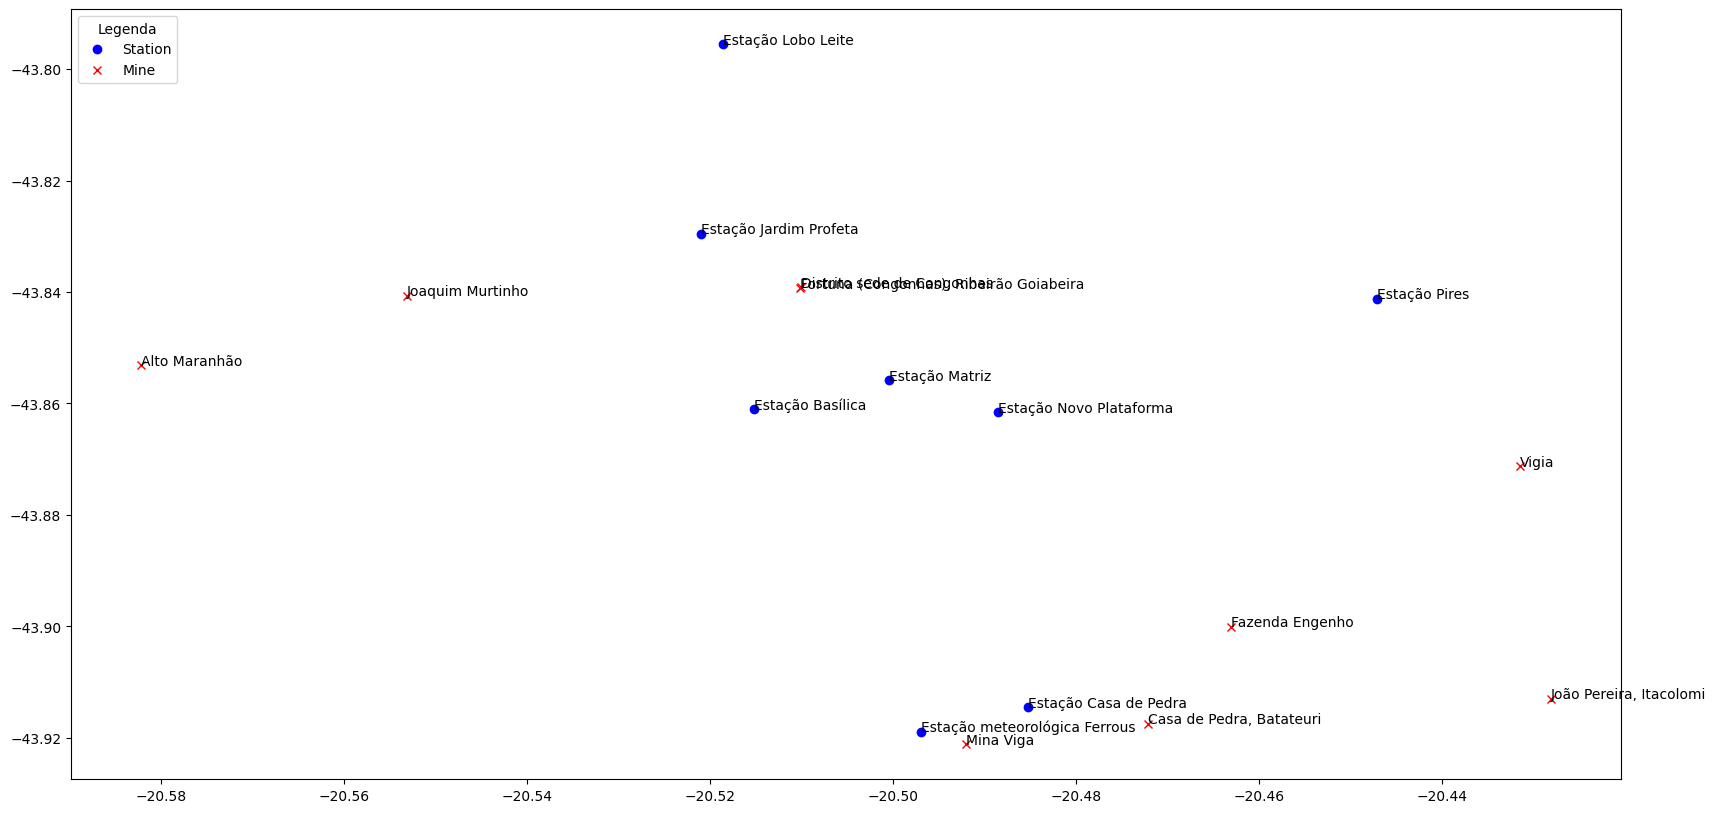

In [9]:
fig, axs = plt.subplots(figsize=(20, 10))

xpoints = np.array(stations['latitude'].values)
ypoints = np.array(stations['longitude'].values)
snames = np.array(stations['nm_estac'].values)

xpoints0 = np.array(minas['Latitude'].values)
ypoints0 = np.array(minas['Longitude'].values)
mnames = np.array(minas['TOPONÍMIA'].values)

plt.plot(xpoints, ypoints, 'o', c='blue', label='Station')
plt.plot(xpoints0, ypoints0, 'x', c='red', label='Mine')

legend = plt.legend(loc="upper left", markerscale=1)

for i, txt in enumerate(snames):
    plt.annotate(txt, (xpoints[i], ypoints[i]))

for i, txt in enumerate(mnames):
    plt.annotate(txt, (xpoints0[i], ypoints0[i]))

legend.set_title("Legenda")
title = legend.get_title()
plt.show()

### Calculating percentage of missing data per column and station

In [10]:
'''
    Columns to be discarted (more than 50% of missing data):

    Basílica:
        None

    Matriz:
        None

    Meteorológica Ferrous:
        Tº
        PA
        RS
        UR

    Lobo Leite:
        None

    Jardim Profeta:
        PTS
        UR
        PA

    Pires:
        PA

    Casa de Pedra
        None

    Novo Plataforma
        None
'''

nan = []; full = []; name = []

for i in df:
  if i == 'Met' or i == 'Casa' or i == 'Pires' or i == 'Jardim': continue
  print(station_nm[i])
  name.append(station_nm[i])
  print(f"{min(df[i]['Timestamp'].dt.date)}\t{max(df[i]['Timestamp'].dt.date)}\t{(max(df[i]['Timestamp'].dt.date) - min(df[i]['Timestamp'].dt.date)).days} days")
  for j in range(len(df[i].columns)):
    foo = round((df[i].isna().sum().values[j]/df[i].shape[0])*100, 2)
    # if foo >= 50: print(df[i].columns[j] + ':\t' + str(foo) + '%')
    # print(df[i].columns[j] + ':\t' + str(foo) + '%')
#   print()

  nan.append(df[i][['PTS', 'PM10', 'PM 2,5']].isna().sum().sum())
  full.append(df[i].shape[0] * 3)
  print('TOTAL: ' + str(df[i].isna().sum().sum()) + '\tIN: ' + str(df[i].shape[0] * df[i].shape[1]) + '\t\t' + str(round(df[i].isna().sum().sum() / (df[i].shape[0] * df[i].shape[1]), 2)*100) + '%')
#   print('FULL EMPTY ROWS: ' + str(df[i].drop('Timestamp', axis='columns').isna().all(axis=1).sum()) + '\tIN: ' + str(df[i].shape[0]) + '\t\t' + str(round(df[i].drop('Timestamp', axis='columns').isna().all(axis=1).sum() / df[i].shape[0], 2)*100) + '%\n')
  print()

Estação Matriz
2017-06-28	2023-12-31	2377 days
TOTAL: 71602	IN: 241485		30.0%

Estação Lobo Leite
2017-05-03	2023-12-31	2433 days
TOTAL: 171600	IN: 876120		20.0%

Estação Novo Plataforma
2017-07-01	2023-12-31	2374 days
TOTAL: 30262	IN: 228000		13.0%

Estação Basílica
2017-08-22	2023-12-31	2322 days
TOTAL: 81717	IN: 613096		13.0%



### Missing/Total data per monitoring station

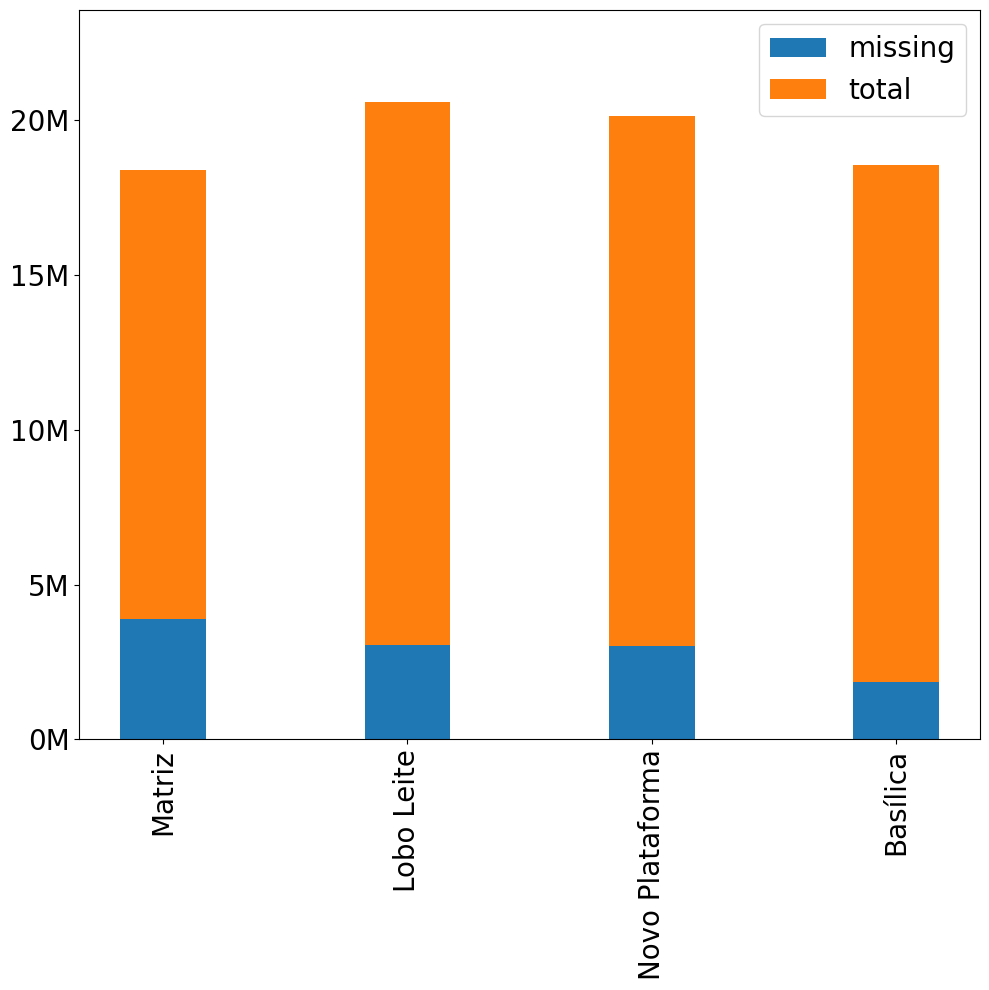

In [11]:
############### ON TEXT #####################
import matplotlib.ticker as ticker

width = 0.35

fig = plt.subplots(figsize =(10, 10))
foo_name = ['Matriz', 'Lobo Leite', 'Novo Plataforma', 'Basílica']
p1 = plt.bar(foo_name, nan, width)
p2 = plt.bar(foo_name, full, width, bottom = nan)

plt.xticks(foo_name, rotation='vertical')
val = (max(full) + max(nan))

def format_func(value, tick_number):
    return f'{int(value / 10000)}M'

plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(format_func))
plt.ylim(0, val*1.1)
plt.legend((p1[0], p2[0]), ('missing', 'total'), fontsize=20)

plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.tight_layout()
plt.savefig(f"total.png", transparent=True, bbox_inches='tight')

plt.show()

### Data Window (Plot)  - 2019/06/02 - 2019/06/09


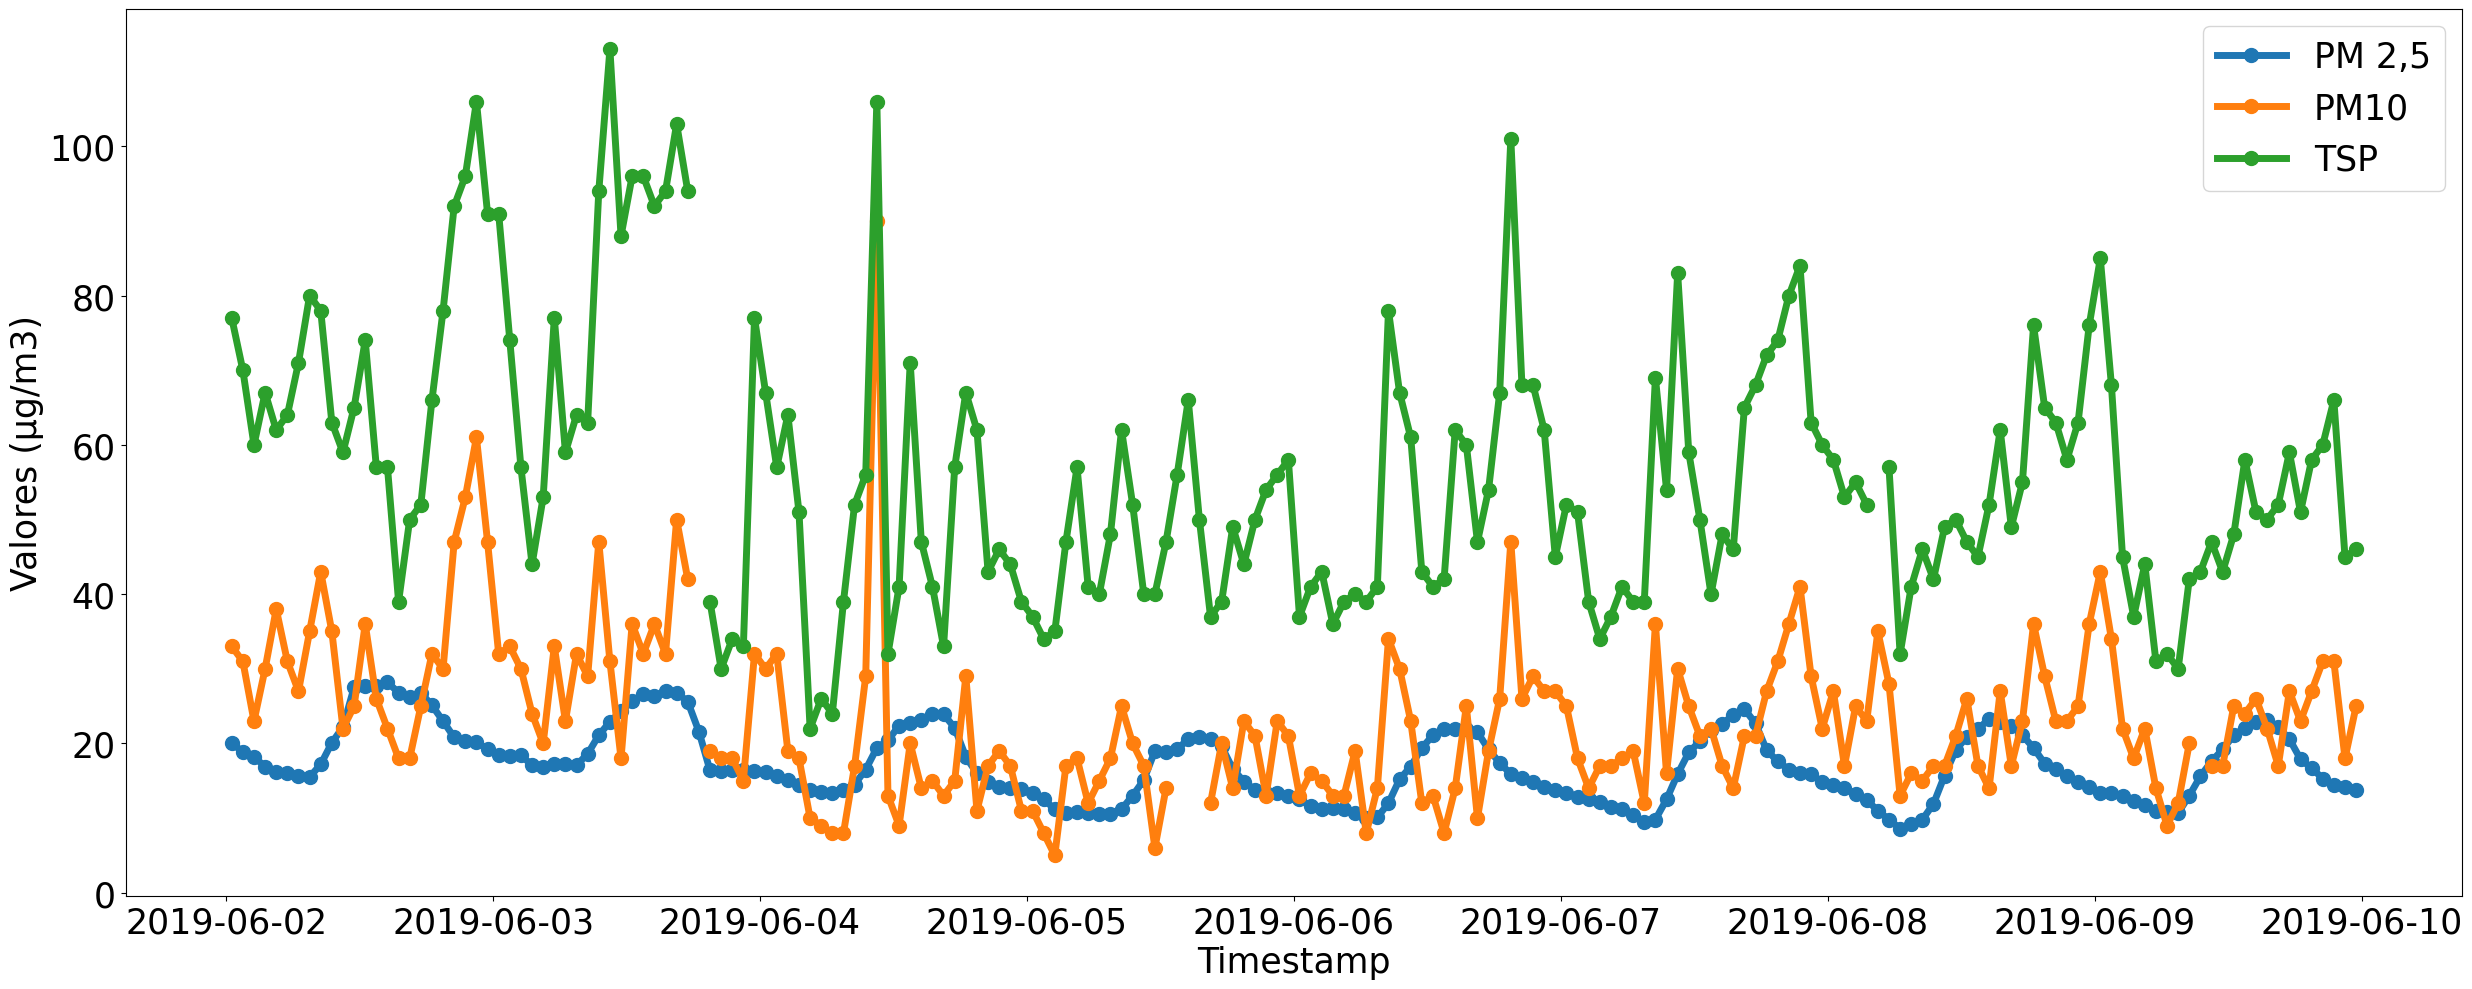

In [12]:
############### ON TEXT #####################

from datetime import datetime
fig, axs = plt.subplots(1, 1, figsize=(25, 10))

foo = df['Basilica'].copy()
foo = foo.drop(['DV', 'UR', 'Tº', 'VV'], axis='columns')
# foo = foo[13770:13800]
foo = foo[(foo['Timestamp'].dt.year == 2019) & (foo['Timestamp'].dt.month == 6)]
foo = foo[(foo['Timestamp'].dt.day >= 2) & (foo['Timestamp'].dt.day <= 9)].copy()
plt.plot(foo['Timestamp'], foo[['PM 2,5', 'PM10', 'PTS']], '.-', markersize=20, linewidth=5, label=['PM 2,5','PM10', 'TSP'])
plt.xlabel('Timestamp', fontsize=25)
plt.ylabel('Valores (µg/m3)', fontsize=25)
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.legend(fontsize=25)
plt.tight_layout()
plt.savefig(f"data.png", transparent=True, bbox_inches='tight')
plt.show()

# Selecting data windows and inserting missing data

## 24 instances - 5 missing

In [13]:
random.seed(42)
num_instances = 24
missing_pm10_24 = random.sample(range(0, num_instances), math.ceil(num_instances*0.2))
missing_pm25_24 = random.sample(range(0, num_instances), math.ceil(num_instances*0.2))
missing_pts_24 = random.sample(range(0, num_instances), math.ceil(num_instances*0.2))

df_basilica_missing_24 = df['Basilica'].copy()

df_basilica_24 = df['Basilica'][df['Basilica']['Timestamp'].dt.year == 2022][:num_instances].copy().reset_index(drop=True)
for i, j, k in zip(missing_pm10_24, missing_pm25_24, missing_pts_24):
  df_basilica_24.at[i, 'PM10'] = np.nan
  df_basilica_missing_24.at[list(df['Basilica']['Timestamp'].values)
  .index(df_basilica_24.iloc[i]['Timestamp']), 'PM10'] = np.nan
  df_basilica_24.at[j, 'PM 2,5'] = np.nan
  df_basilica_missing_24.at[list(df['Basilica']['Timestamp'].values)
  .index(df_basilica_24.iloc[j]['Timestamp']), 'PM 2,5'] = np.nan
  df_basilica_24.at[k, 'PTS'] = np.nan
  df_basilica_missing_24.at[list(df['Basilica']['Timestamp'].values)
  .index(df_basilica_24.iloc[k]['Timestamp']), 'PTS'] = np.nan

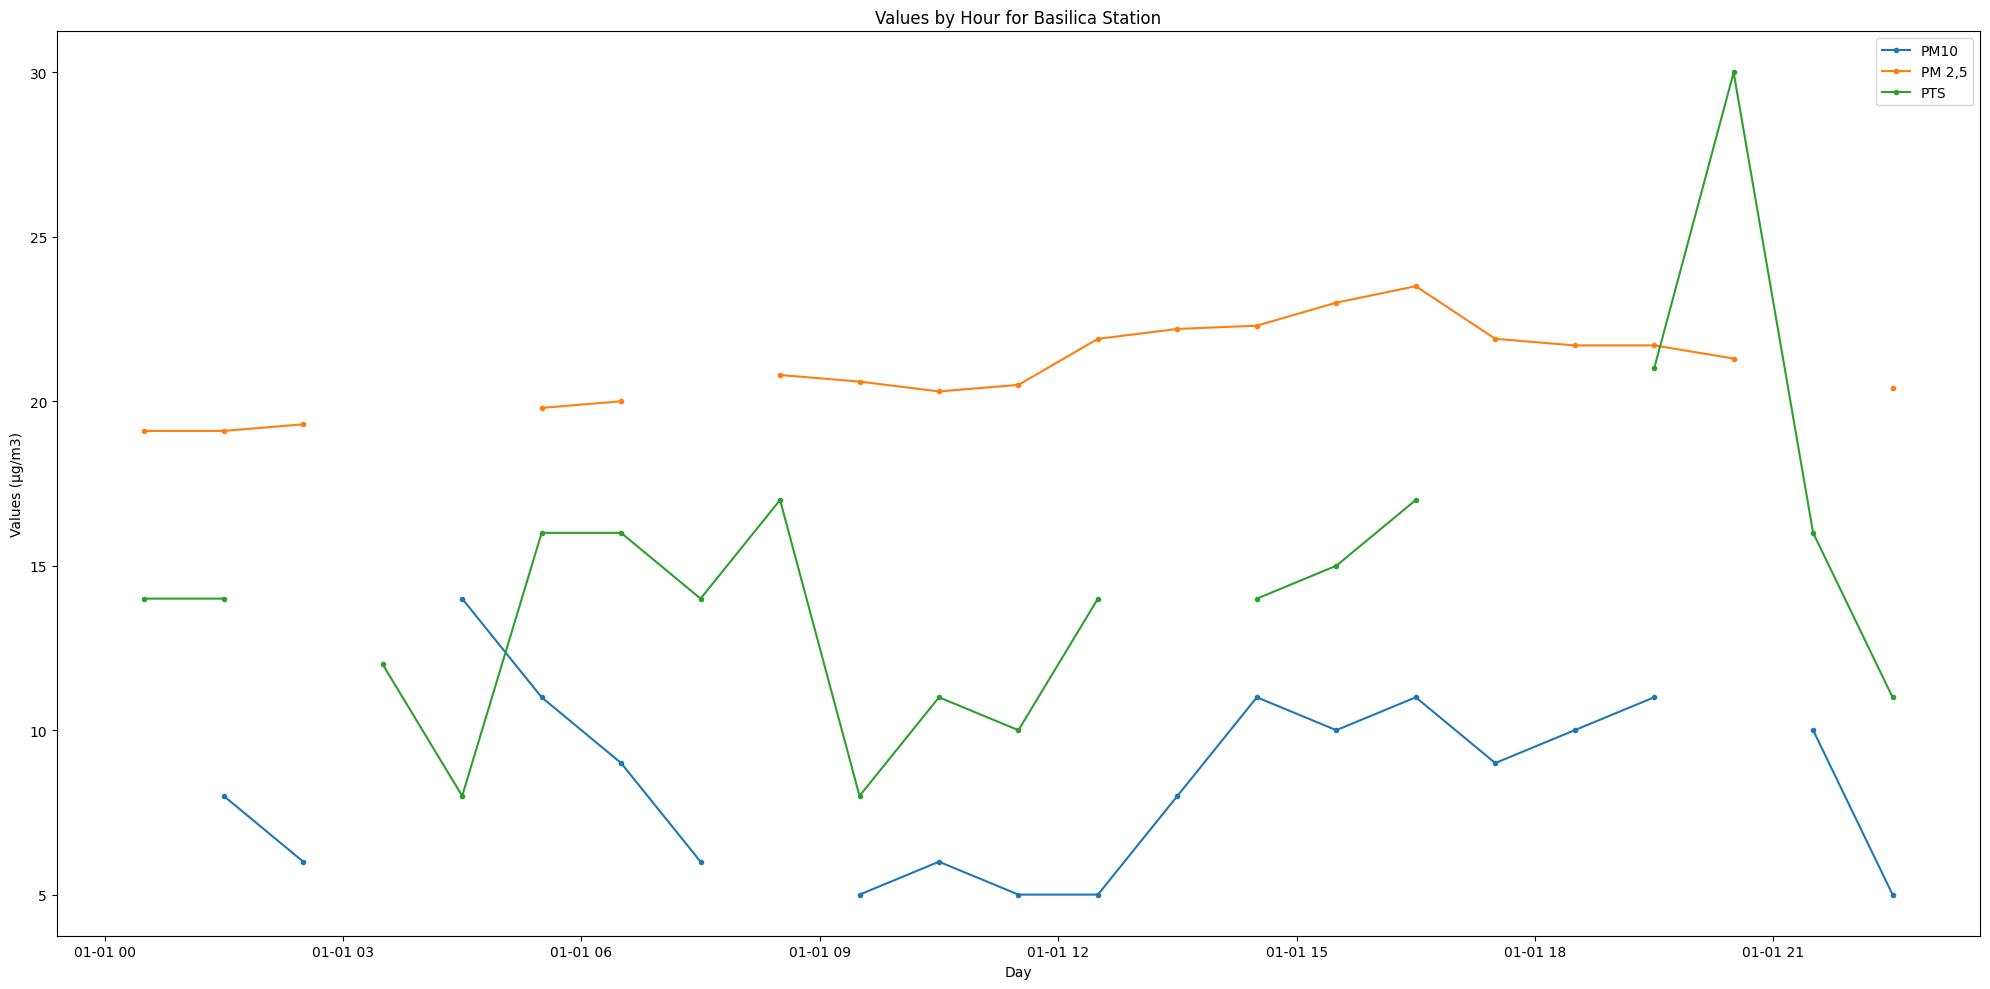

In [14]:
fig, axs = plt.subplots(1, 1, figsize=(20, 10))

foo = df_basilica_24.copy()
foo = foo.drop(['DV', 'UR', 'Tº', 'VV'], axis='columns')
plt.plot(foo['Timestamp'], foo[['PM10', 'PM 2,5', 'PTS']], '.-', label=['PM10', 'PM 2,5', 'PTS'])
plt.xlabel('Day')
plt.ylabel('Values (µg/m3)')
plt.title('Values by Hour for Basilica Station')
plt.legend()
plt.tight_layout()
plt.show()

## 48 instances - 10 missing

In [15]:
random.seed(42)
num_instances = 48
missing_pm10_48 = random.sample(range(0, num_instances), math.ceil(num_instances*0.2))
missing_pm25_48 = random.sample(range(0, num_instances), math.ceil(num_instances*0.2))
missing_pts_48 = random.sample(range(0, num_instances), math.ceil(num_instances*0.2))

df_basilica_missing_48 = df['Basilica'].copy()

df_basilica_48 = df['Basilica'][df['Basilica']['Timestamp'].dt.year == 2022][:num_instances].copy().reset_index(drop=True)
for i, j, k in zip(missing_pm10_48, missing_pm25_48, missing_pts_48):
  df_basilica_48.at[i, 'PM10'] = np.nan
  df_basilica_missing_48.at[list(df['Basilica']['Timestamp'].values)
  .index(df_basilica_48.iloc[i]['Timestamp']), 'PM10'] = np.nan
  df_basilica_48.at[j, 'PM 2,5'] = np.nan
  df_basilica_missing_48.at[list(df['Basilica']['Timestamp'].values)
  .index(df_basilica_48.iloc[j]['Timestamp']), 'PM 2,5'] = np.nan
  df_basilica_48.at[k, 'PTS'] = np.nan
  df_basilica_missing_48.at[list(df['Basilica']['Timestamp'].values)
  .index(df_basilica_48.iloc[k]['Timestamp']), 'PTS'] = np.nan

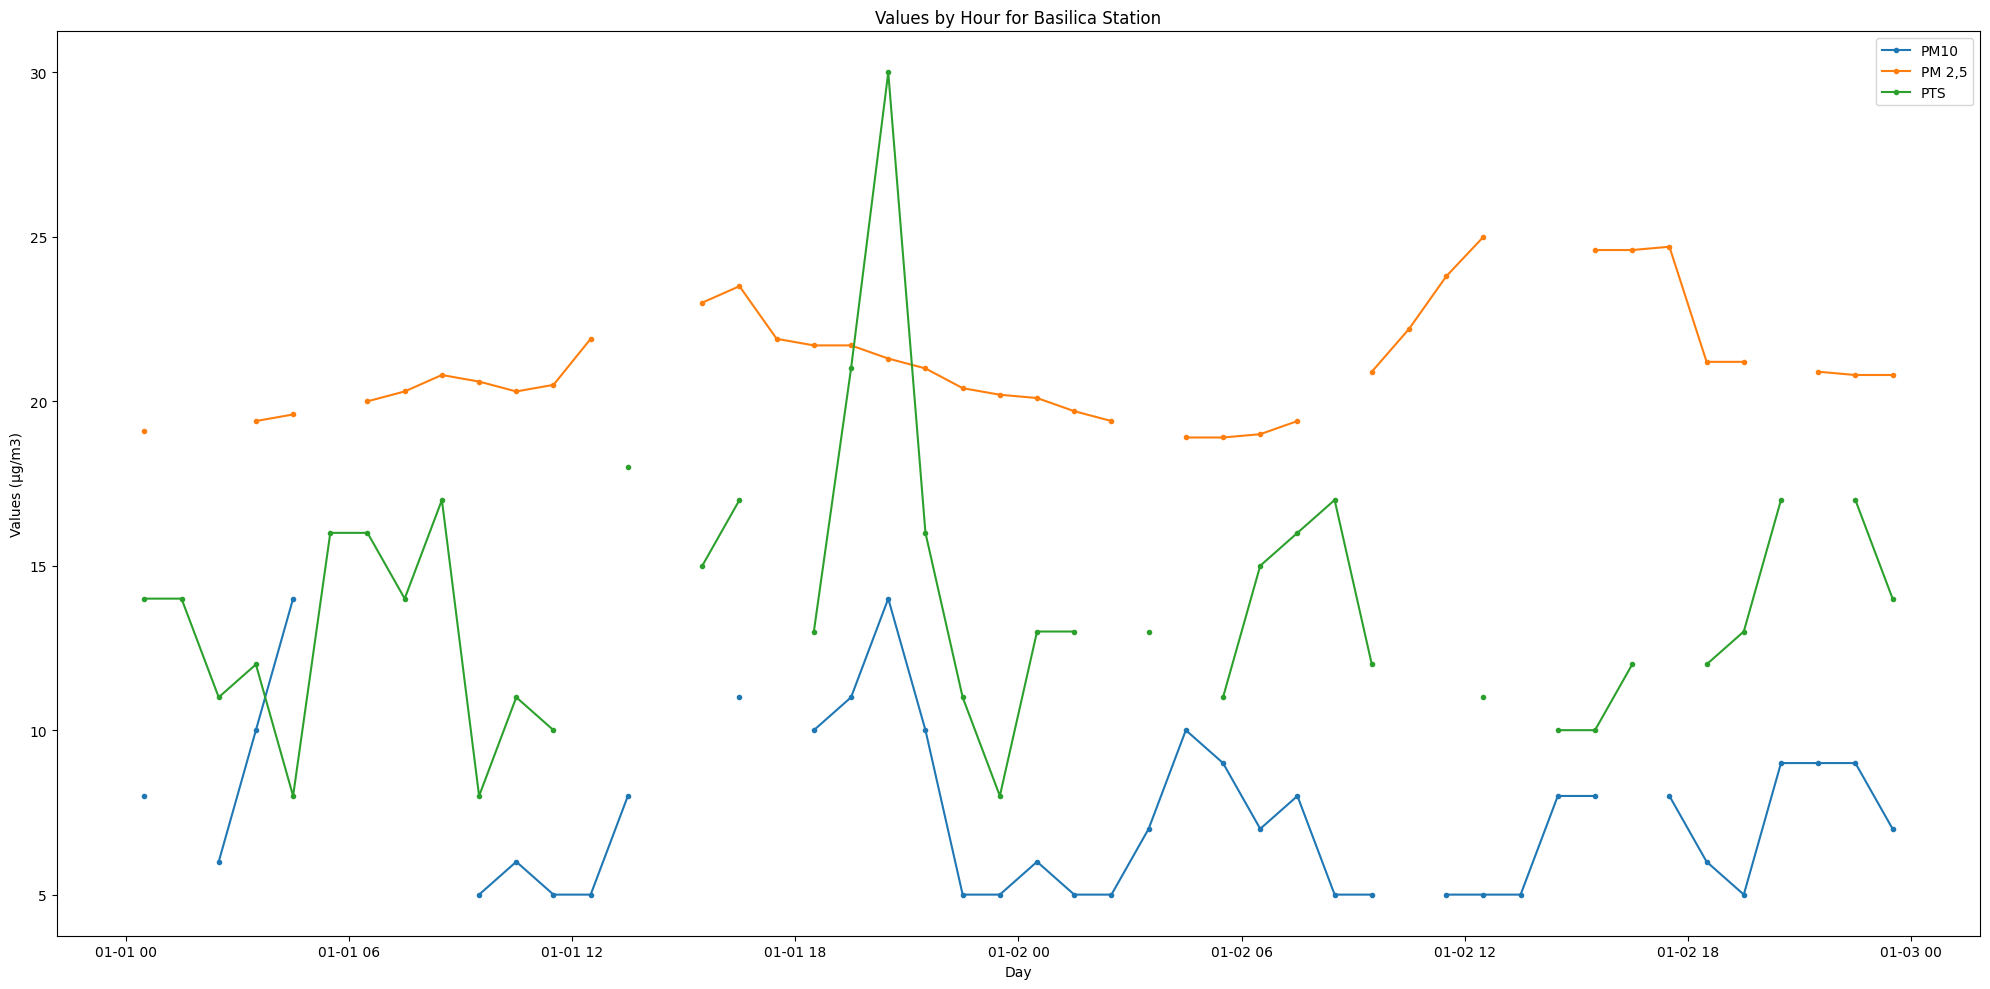

In [16]:
fig, axs = plt.subplots(1, 1, figsize=(20, 10))

foo = df_basilica_48.copy()
foo = foo.drop(['DV', 'UR', 'Tº', 'VV'], axis='columns')
plt.plot(foo['Timestamp'], foo[['PM10', 'PM 2,5', 'PTS']], '.-', label=['PM10', 'PM 2,5', 'PTS'])
plt.xlabel('Day')
plt.ylabel('Values (µg/m3)')
plt.title('Values by Hour for Basilica Station')
plt.legend()
plt.tight_layout()
plt.show()

## 72 instances - 15 missing

In [17]:
random.seed(42)
num_instances = 72
missing_pm10_72 = random.sample(range(0, num_instances), math.ceil(num_instances*0.2))
missing_pm25_72 = random.sample(range(0, num_instances), math.ceil(num_instances*0.2))
missing_pts_72 = random.sample(range(0, num_instances), math.ceil(num_instances*0.2))

df_basilica_missing_72 = df['Basilica'].copy()

df_basilica_72 = df['Basilica'][df['Basilica']['Timestamp'].dt.year == 2022][:num_instances].copy().reset_index(drop=True)
for i, j, k in zip(missing_pm10_72, missing_pm25_72, missing_pts_72):
  df_basilica_72.at[i, 'PM10'] = np.nan
  df_basilica_missing_72.at[list(df['Basilica']['Timestamp'].values)
  .index(df_basilica_72.iloc[i]['Timestamp']), 'PM10'] = np.nan
  df_basilica_72.at[j, 'PM 2,5'] = np.nan
  df_basilica_missing_72.at[list(df['Basilica']['Timestamp'].values)
  .index(df_basilica_72.iloc[j]['Timestamp']), 'PM 2,5'] = np.nan
  df_basilica_72.at[k, 'PTS'] = np.nan
  df_basilica_missing_72.at[list(df['Basilica']['Timestamp'].values)
  .index(df_basilica_72.iloc[k]['Timestamp']), 'PTS'] = np.nan

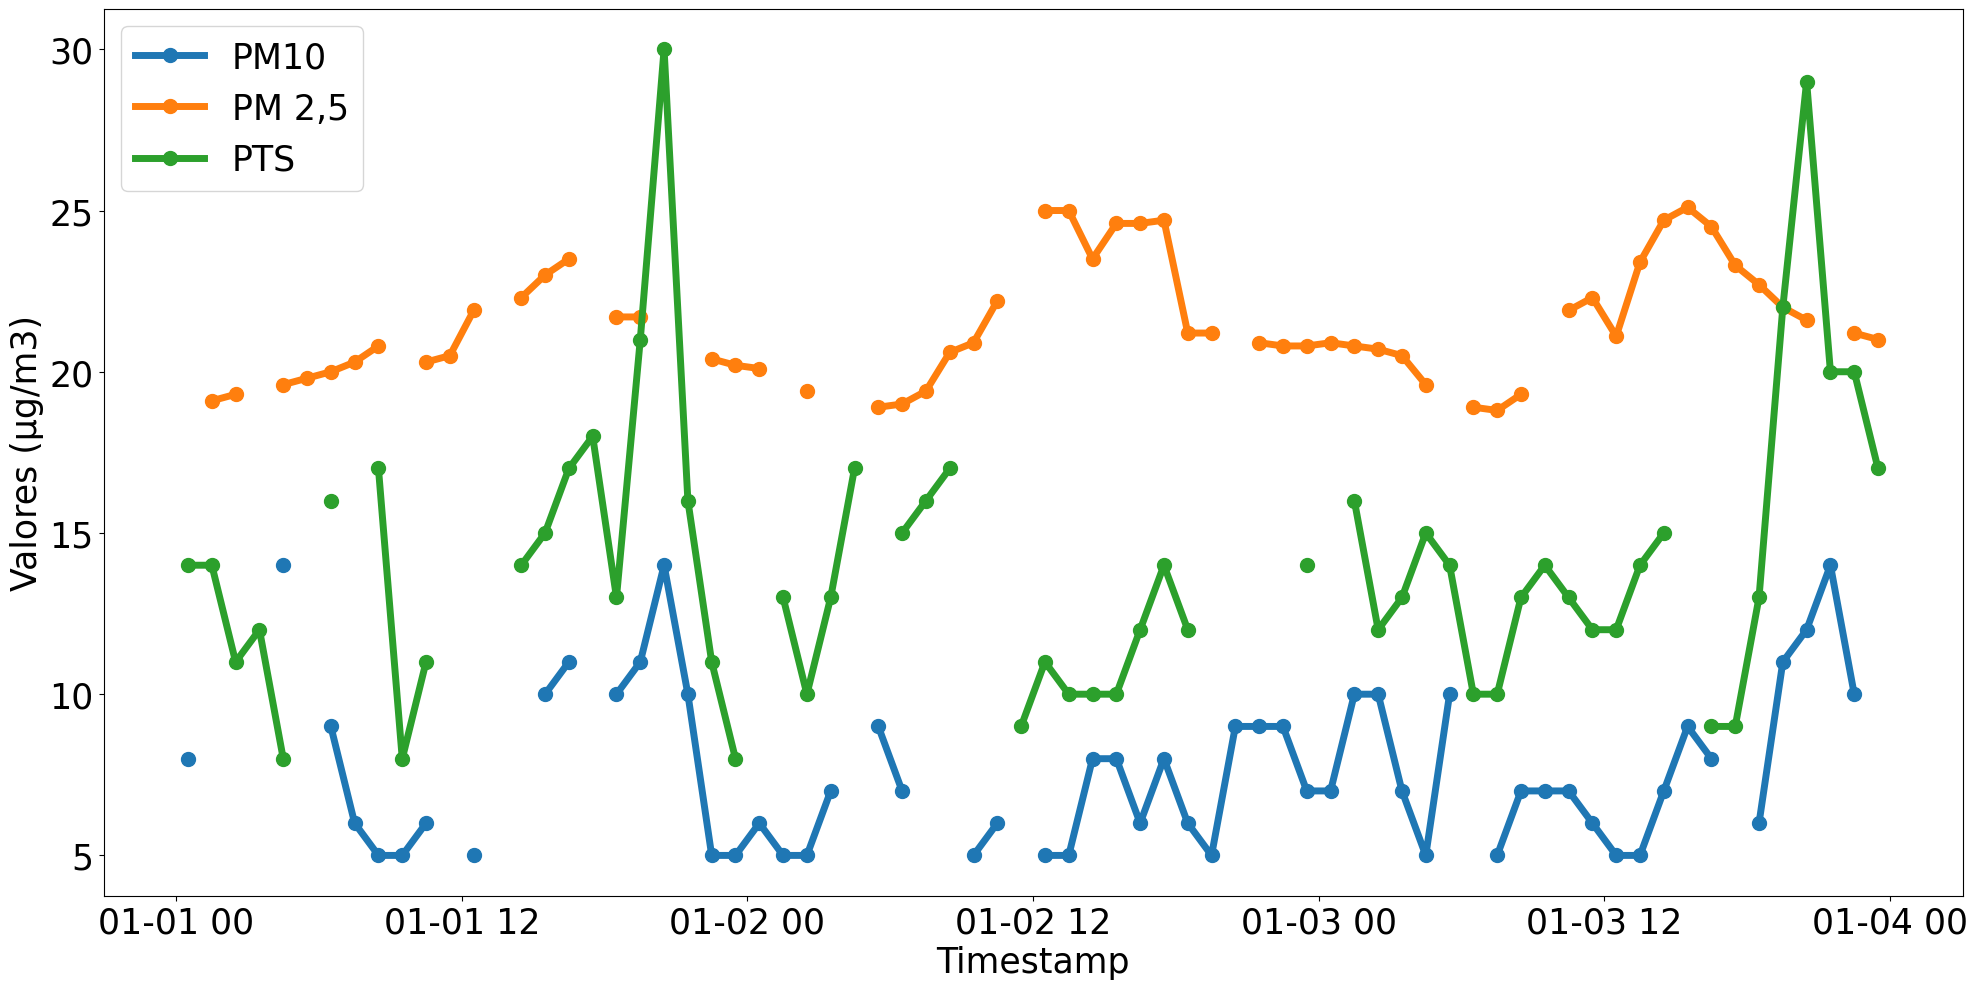

In [18]:
fig, axs = plt.subplots(1, 1, figsize=(20, 10))

foo = df_basilica_72.copy()
# foo = df['Basilica'][df['Basilica']['Timestamp'].dt.year == 2022][:72].copy()
foo = foo.drop(['DV', 'UR', 'Tº', 'VV'], axis='columns')
plt.plot(foo['Timestamp'], foo[['PM10', 'PM 2,5', 'PTS']], '.-', label=['PM10', 'PM 2,5', 'PTS'], markersize=20, linewidth=5)
plt.xlabel('Timestamp', fontsize=25)
plt.ylabel('Valores (µg/m3)', fontsize=25)
plt.yticks(fontsize=25)
plt.xticks(fontsize=25)
plt.legend(fontsize=25)
plt.tight_layout()
plt.savefig(f"imputed.png", transparent=True, bbox_inches='tight')
plt.show()

# Data Imputation

## Defining Metric Calculation and Plot Functions

In [19]:
# Metrics organization
# [mse, mae, r2, nrmse]

def calculate_metric(df, pred, n):
    foo = df['Basilica'][df['Basilica']['Timestamp'].dt.year == 2022][:n]
    pred = pred[pred['Timestamp'].dt.year == 2022][:n].copy()

    metrics_dict = {}
    pred_columns = []

    if 'PM25' in pred.columns:
        pred_columns = ['PM10', 'PM25', 'PTS']
    else:
        pred_columns = ['PM10', 'PM 2,5', 'PTS']

    for i, j in zip(['PM10', 'PM 2,5', 'PTS'], pred_columns):
        mse = mean_squared_error(foo[i], pred[j])
        mae = mean_absolute_error(foo[i], pred[j])
        r2 = r2_score(foo[i], pred[j])
        nrmse = root_mean_squared_error(foo[i], pred[j]) / (foo[i].max() - foo[i].min())
        metrics_dict[i] = [mse, mae, r2, nrmse]
        print(f'MSE for {i}: {mse}')
        print(f'MAE for {i}: {mae}')
        print(f'R² for {i}: {r2}')
        print(f'NRMSE for {i}: {nrmse}')
        print()
    return metrics_dict

## MICE Imputer

In [20]:
def mice_imputation(df, n):
    df_copy = df.copy()
    df_copy = df_copy.rename(columns={"PM 2,5": "PM25", "Tº": "T"})

    # Create kernel.
    kds = mf.ImputationKernel(
    df_copy.iloc[:,1:],
    random_state=0
    )

    # Run the MICE algorithm for n iterations
    kds.mice(n)

    # Return the completed dataset.
    mice_imputed = kds.complete_data()
    mice_imputed['Timestamp'] = df['Timestamp']
    return mice_imputed

In [21]:
mice_imputed_24 = mice_imputation(df_basilica_missing_24, 10)
metrics_dict_mice_24 = calculate_metric(df, mice_imputed_24, 24)

MSE for PM10: 10.916666666666666
MAE for PM10: 1.25
R² for PM10: -0.3948535936113575
NRMSE for PM10: 0.3671153259555372

MSE for PM 2,5: 1.7354166666666666
MAE for PM 2,5: 0.4958333333333333
R² for PM 2,5: -0.19445075101270293
NRMSE for PM 2,5: 0.2993982141456573

MSE for PTS: 34.916666666666664
MAE for PTS: 2.3333333333333335
R² for PTS: -0.61205514588009
NRMSE for PTS: 0.2685923924429672



In [22]:
mice_imputed_48 = mice_imputation(df_basilica_missing_48, 10)
metrics_dict_mice_48 = calculate_metric(df, mice_imputed_48, 48)

MSE for PM10: 4.4375
MAE for PM10: 0.7708333333333334
R² for PM10: 0.24862203277724693
NRMSE for PM10: 0.23405971592156552

MSE for PM 2,5: 0.412916666666667
MAE for PM 2,5: 0.24166666666666678
R² for PM 2,5: 0.8646542734428682
NRMSE for PM 2,5: 0.10534195436424593

MSE for PTS: 14.416666666666666
MAE for PTS: 1.2916666666666667
R² for PTS: 0.042435424354243634
NRMSE for PTS: 0.17258766287718966



In [23]:
mice_imputed_72 = mice_imputation(df_basilica_missing_72, 10)
metrics_dict_mice_72 = calculate_metric(df, mice_imputed_72, 72)

MSE for PM10: 15.708333333333334
MAE for PM10: 1.0694444444444444
R² for PM10: -1.667452830188679
NRMSE for PM10: 0.4403748870590413

MSE for PM 2,5: 2.8752777777777783
MAE for PM 2,5: 0.5861111111111111
R² for PM 2,5: 0.06636300087942804
NRMSE for PM 2,5: 0.26915308031757473

MSE for PTS: 12.916666666666666
MAE for PTS: 1.4444444444444444
R² for PTS: 0.23707088085499106
NRMSE for PTS: 0.16336256555187745



## KNN Imputer

In [24]:
def knn_imputation(df, n):
    df_copy = df.copy()
    imputer = KNNImputer(n_neighbors=n, weights="uniform", add_indicator=True)
    imputer.set_output(transform="pandas")
    X = imputer.fit_transform(df_copy.copy().drop('Timestamp', axis='columns'))

    df_copy = X.copy()
    df_copy['Timestamp'] = df['Timestamp']
    return df_copy

In [25]:
# Selected window with 24 instances
knn_imputed_24 = knn_imputation(df_basilica_missing_24, 48)
metrics_dict_24 = calculate_metric(df, knn_imputed_24, 24)

MSE for PM10: 8.137116608796298
MAE for PM10: 1.076388888888889
R² for PM10: -0.03970256580893228
NRMSE for PM10: 0.31695146274820357

MSE for PM 2,5: 0.2186366102430554
MAE for PM 2,5: 0.19314236111111116
R² for PM 2,5: 0.8495170247469739
NRMSE for PM 2,5: 0.10626953156479425

MSE for PTS: 25.05705656828704
MAE for PTS: 1.8376736111111114
R² for PTS: -0.15685031927968418
NRMSE for PTS: 0.22753192750392398



In [26]:
# Selected window with 48 instances
knn_imputed_48 = knn_imputation(df_basilica_missing_48, 48)
metrics_dict_48 = calculate_metric(df, knn_imputed_48, 48)

MSE for PM10: 4.317066333912037
MAE for PM10: 0.8346354166666666
R² for PM10: 0.26901441659929926
NRMSE for PM10: 0.2308616798723468

MSE for PM 2,5: 0.09111635561342585
MAE for PM 2,5: 0.1155381944444444
R² for PM 2,5: 0.9701339026799505
NRMSE for PM 2,5: 0.04948440303641766

MSE for PTS: 27.678430627893515
MAE for PTS: 2.189670138888889
R² for PTS: -0.8384197465021521
NRMSE for PTS: 0.23913770121057001



In [27]:
# Selected window with 72 instances
knn_imputed_72 = knn_imputation(df_basilica_missing_72, 48)
metrics_dict_72 = calculate_metric(df, knn_imputed_72, 72)

MSE for PM10: 4.285451630015432
MAE for PM10: 0.7404513888888888
R² for PM10: 0.27228179867662483
NRMSE for PM10: 0.2300148044085513

MSE for PM 2,5: 0.2890995129243827
MAE for PM 2,5: 0.19675925925925913
R² for PM 2,5: 0.9061259389336119
NRMSE for PM 2,5: 0.08534599196966153

MSE for PTS: 17.246588059413583
MAE for PTS: 1.7291666666666667
R² for PTS: -0.018678005400663222
NRMSE for PTS: 0.18876823462581588



## Results

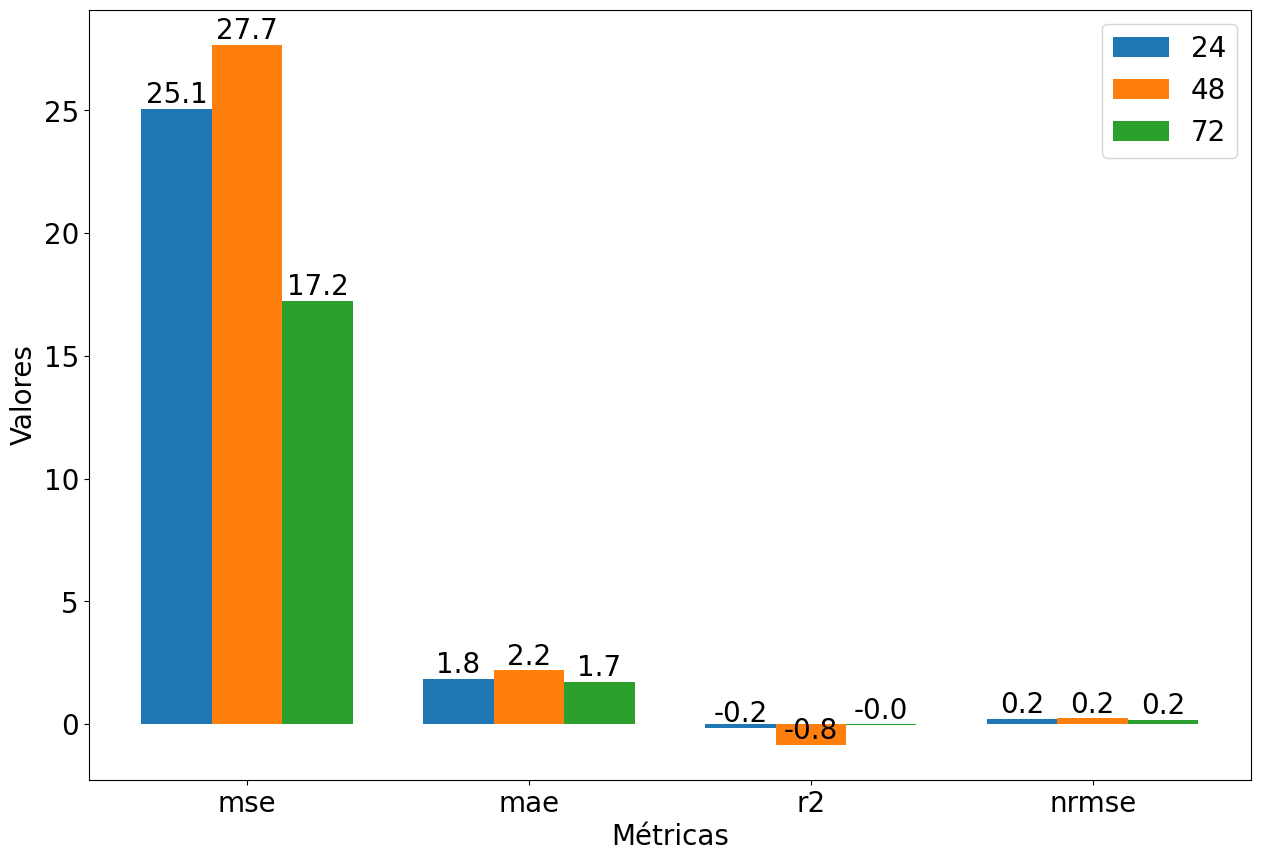

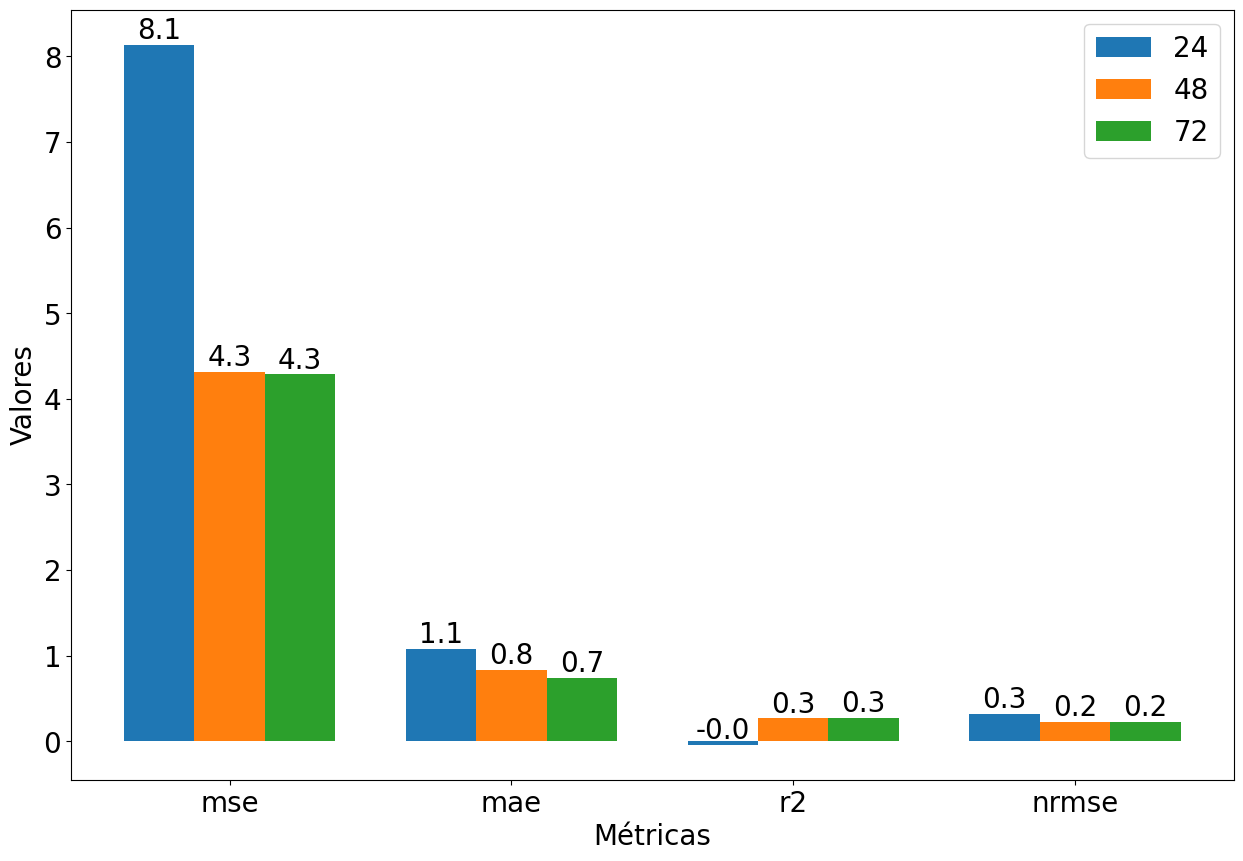

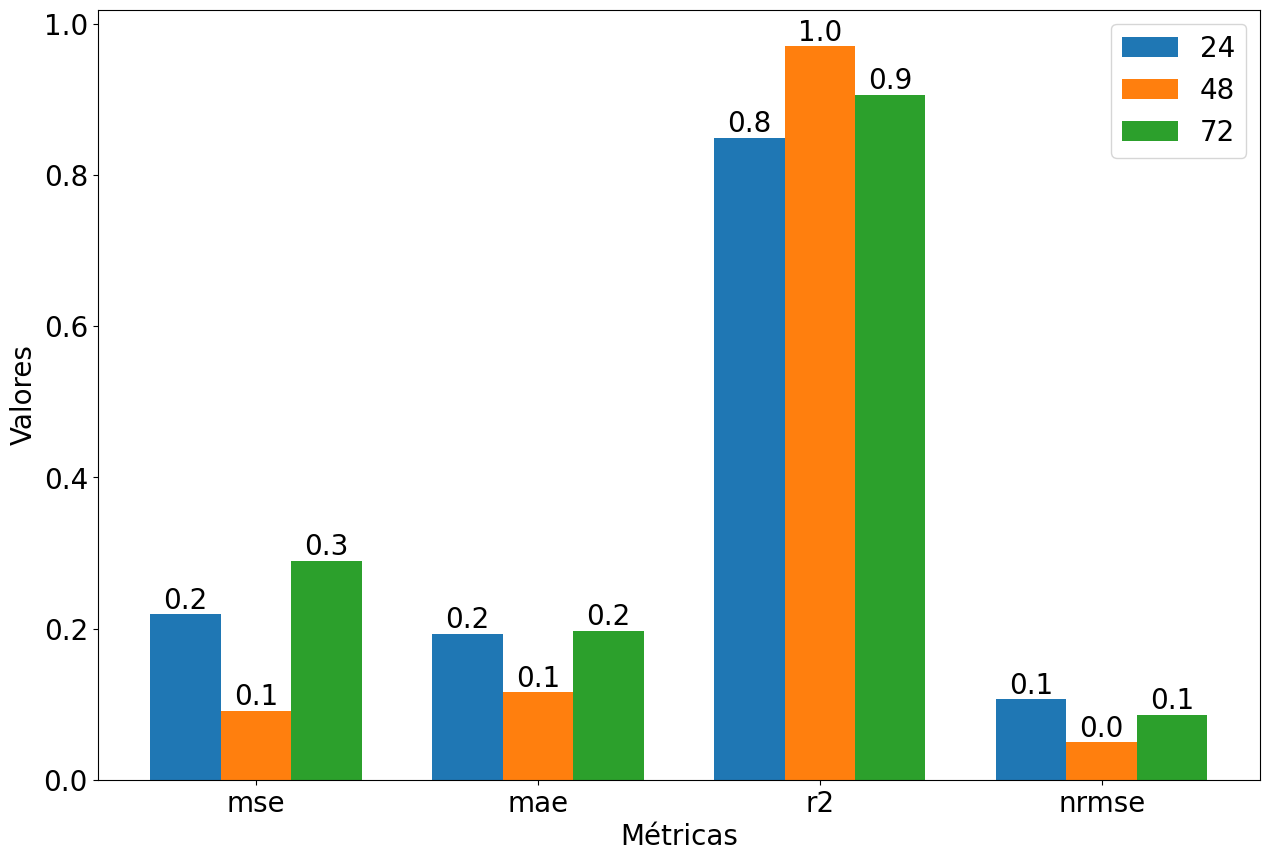

In [28]:
N = 4
ind = np.arange(N)  # the x locations for the groups
width = 0.25       # the width of the bars


for i in ['PTS', 'PM10', 'PM 2,5']:
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111)

    rects1 = ax.bar(ind, metrics_dict_24[i], width)
    rects2 = ax.bar(ind+width, metrics_dict_48[i], width)
    rects3 = ax.bar(ind+width*2, metrics_dict_72[i], width)

    ax.set_ylabel('Valores', fontsize=20)
    ax.set_xlabel('Métricas', fontsize=20)
    ax.set_xticks(ind+width)
    ax.set_xticklabels( ('mse', 'mae', 'r2', 'nrmse'))
    ax.legend( (rects1[0], rects2[0], rects3[0]), ('24', '48', '72'), fontsize=20)

    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    def autolabel(rects):
        for rect in rects:
            h = rect.get_height()
            ax.text(rect.get_x()+rect.get_width()/2, 1.*h, float("{:.1f}".format(h)),
                    ha='center', va='bottom', fontsize=20)

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)

    plt.savefig(f"KnnImputer{i}.png", transparent=True, bbox_inches='tight')

    plt.show()

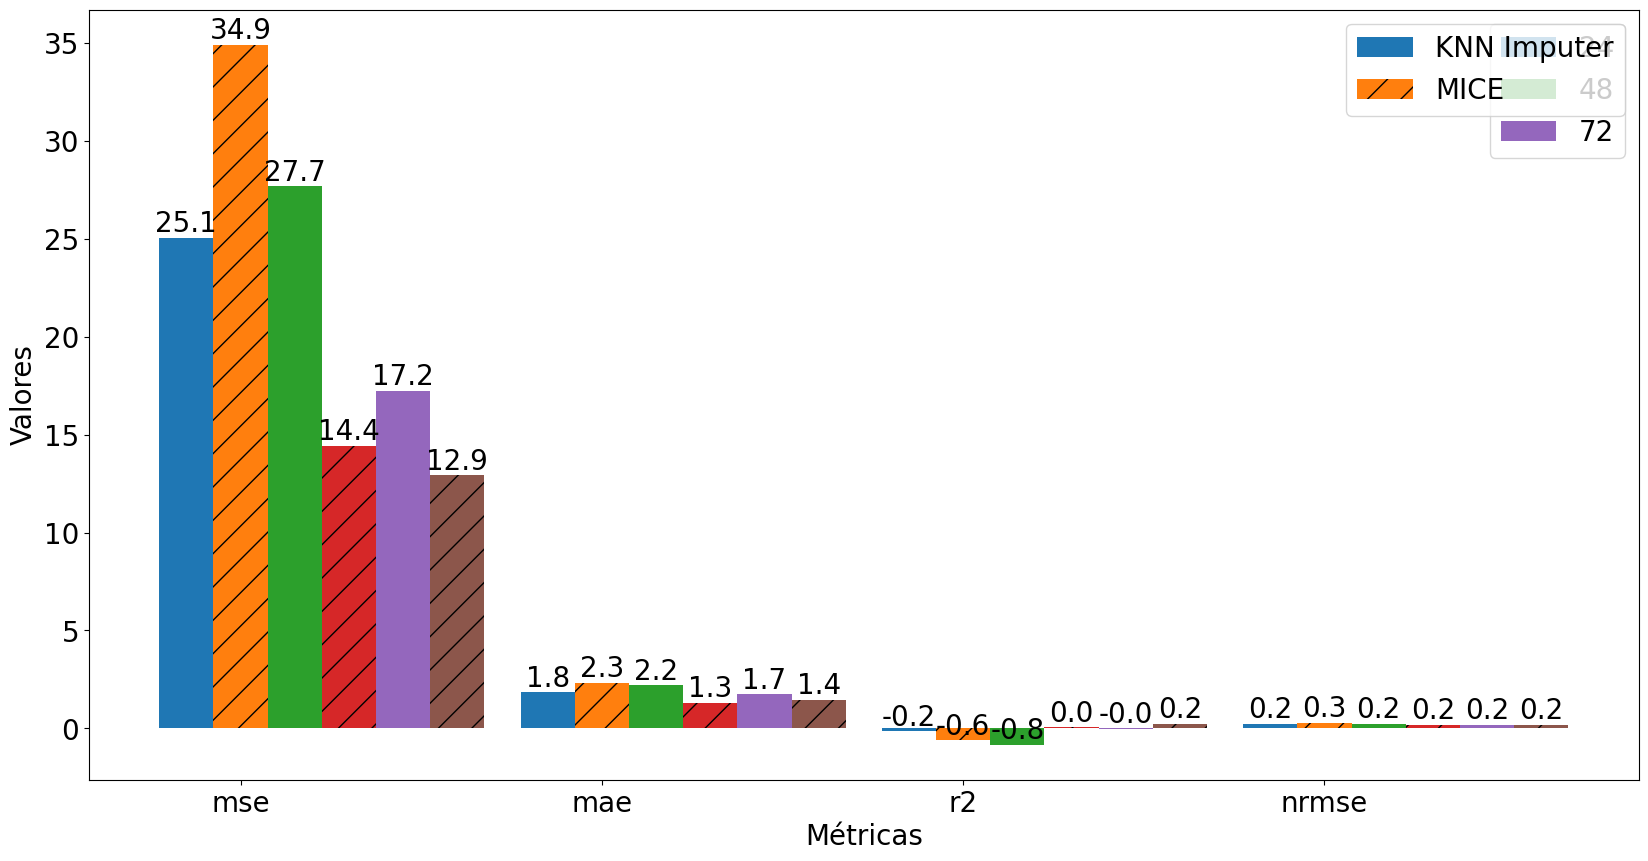

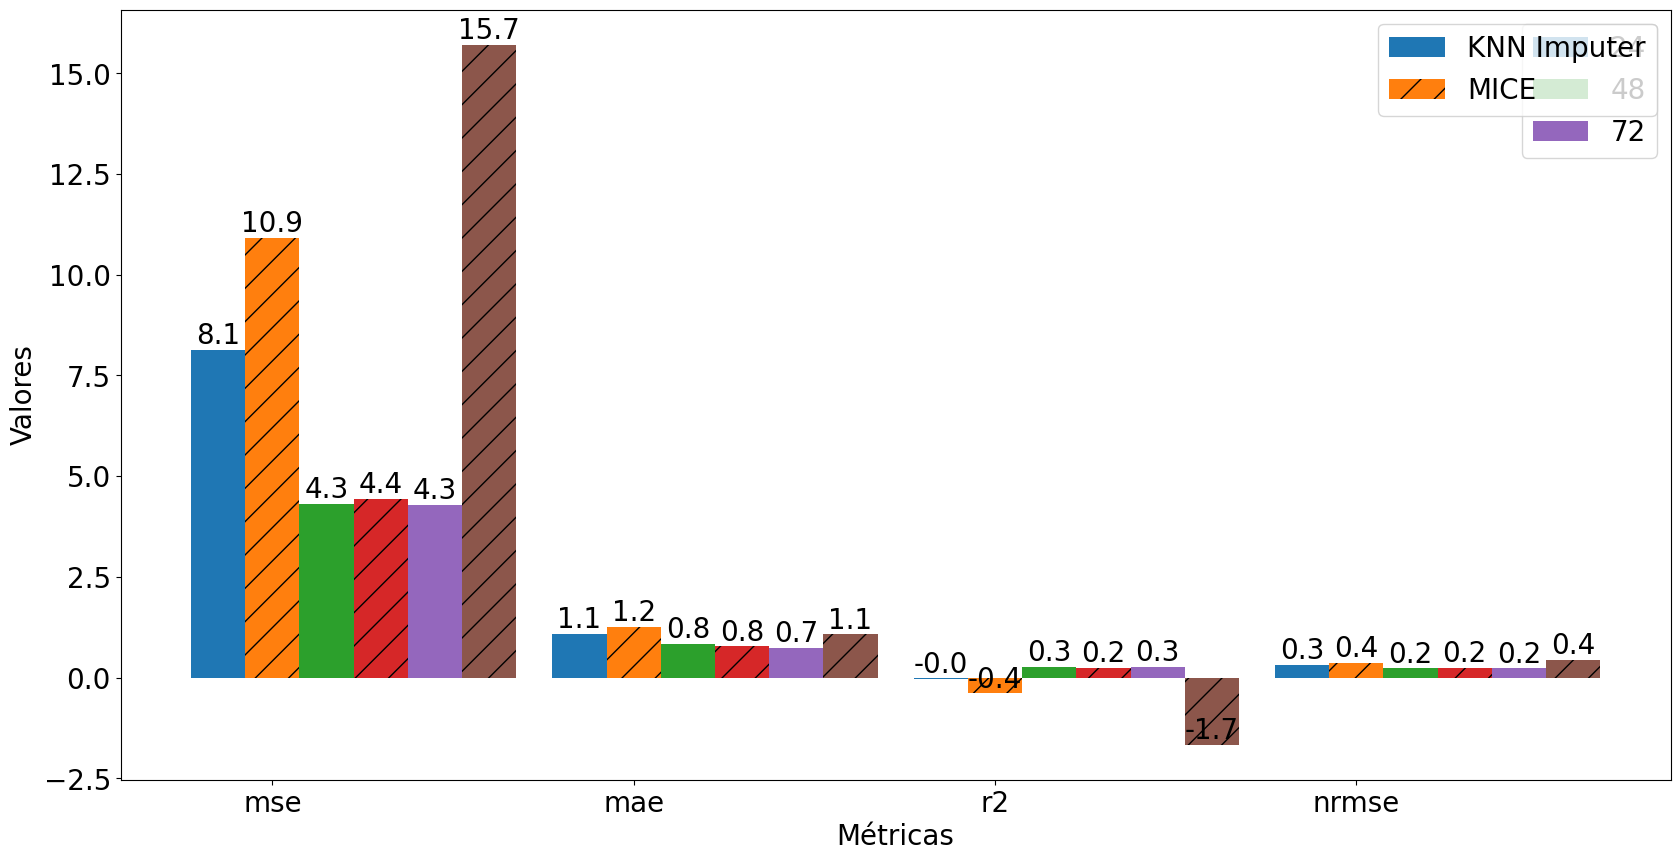

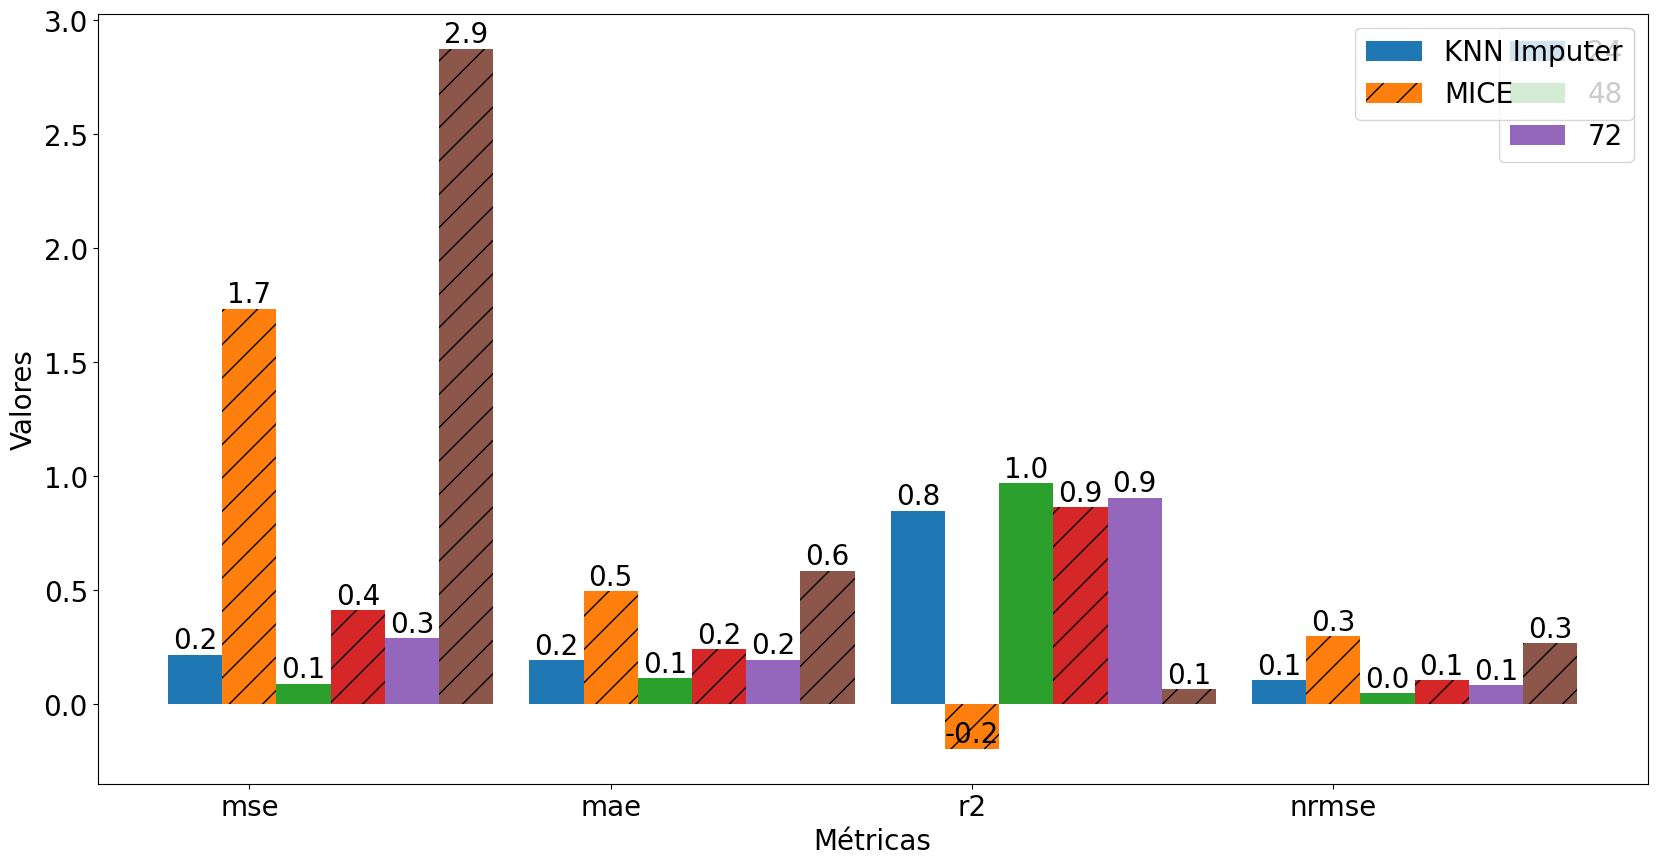

In [29]:
N = 4
ind = np.arange(N)  # the x locations for the groups
width = 0.3       # the width of the bars
spacing = 1  # additional space between groups of bars
ind_with_spacing = ind + (width * 1.5) + spacing * np.arange(len(ind))


for i in ['PTS', 'PM10', 'PM 2,5']:
    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111)

    rects1 = ax.bar(ind_with_spacing, metrics_dict_24[i], width)
    rects2 = ax.bar(ind_with_spacing+width, metrics_dict_mice_24[i], width, hatch="/")
    rects3 = ax.bar(ind_with_spacing+width*2, metrics_dict_48[i], width)
    rects4 = ax.bar(ind_with_spacing+width*3, metrics_dict_mice_48[i], width, hatch="/")
    rects5 = ax.bar(ind_with_spacing+width*4, metrics_dict_72[i], width)
    rects6 = ax.bar(ind_with_spacing+width*5, metrics_dict_mice_72[i], width, hatch="/")

    ax.set_ylabel('Valores', fontsize=20)
    ax.set_xlabel('Métricas', fontsize=20)
    ax.set_xticks(ind_with_spacing+width)
    ax.set_xticklabels( ('mse', 'mae', 'r2', 'nrmse'))
    first_legend = ax.legend( (rects1[0], rects3[0], rects5[0]), ('24', '48', '72'), fontsize=20)

    # Add the second legend
    second_legend = plt.legend((rects1[1], rects2[1]), ('KNN Imputer', 'MICE'), fontsize=20, facecolor='white')

    # Manually add the first legend back to the plot
    ax.add_artist(first_legend)

    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    def autolabel(rects):
        for rect in rects:
            h = rect.get_height()
            ax.text(rect.get_x()+rect.get_width()/2, 1.*h, float("{:.1f}".format(h)),
                    ha='center', va='bottom', fontsize=20)

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)
    autolabel(rects4)
    autolabel(rects5)
    autolabel(rects6)

    plt.savefig(f"KnnImputer{i}.png", transparent=True, bbox_inches='tight')

    plt.show()

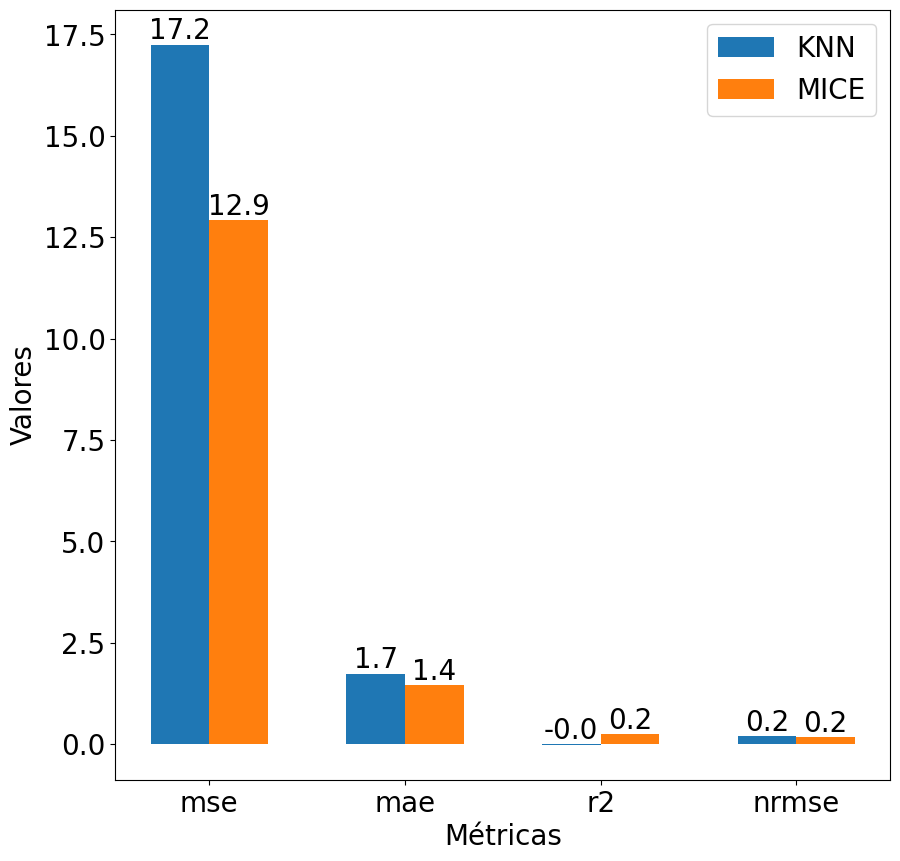

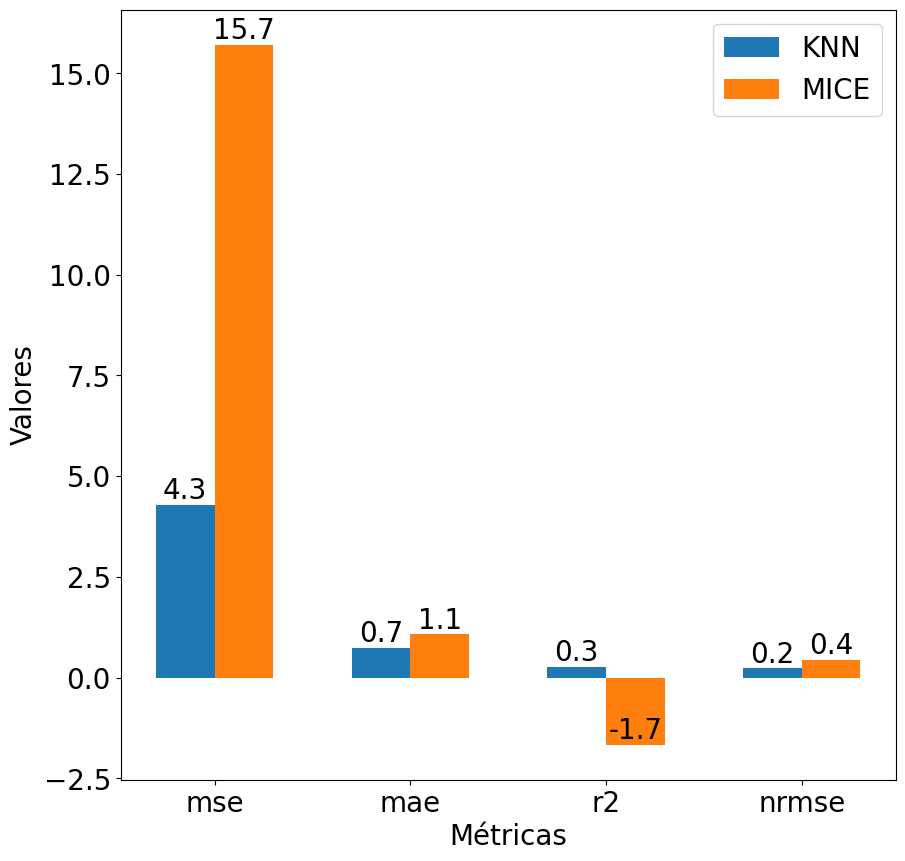

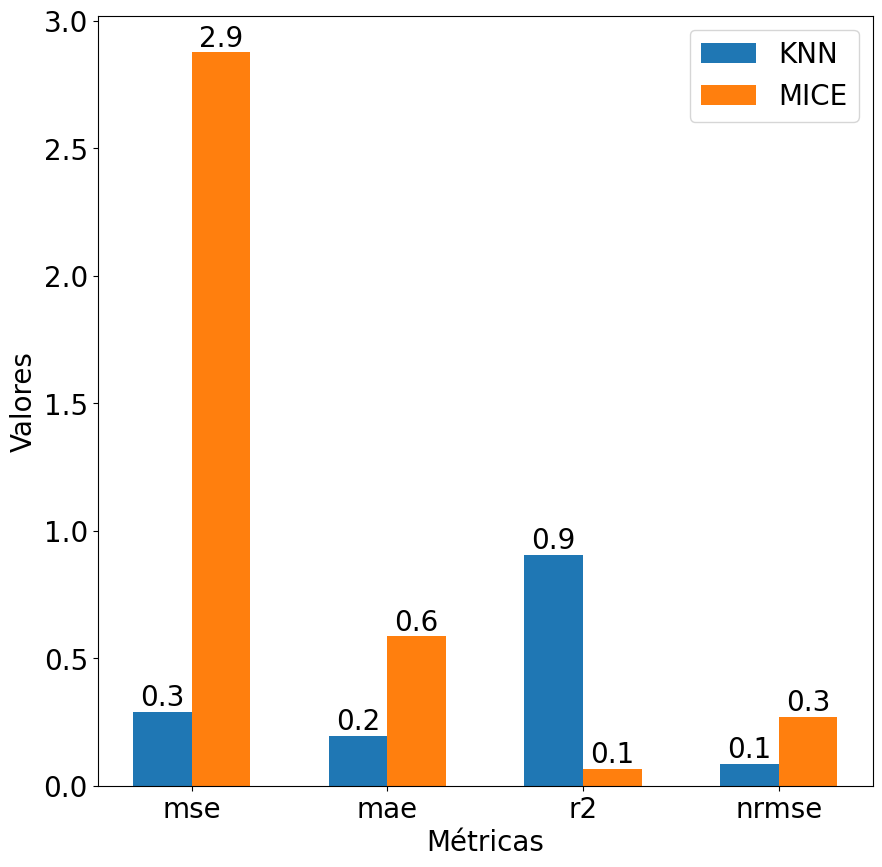

In [30]:
N = 4
ind = np.arange(N)  # the x locations for the groups
width = 0.3      # the width of the bars
spacing = 0  # additional space between groups of bars
ind_with_spacing = ind + (width * 1.5) + spacing * np.arange(len(ind))

for i in ['PTS', 'PM10', 'PM 2,5']:
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)

    # rects1 = ax.bar(ind_with_spacing, simple_mean_metrics_dict_72[i], width)
    # rects2 = ax.bar(ind_with_spacing+width, simple_median_metrics_dict_72[i], width)
    # rects3 = ax.bar(ind_with_spacing+width*2, simple_0_metrics_dict_72[i], width)
    rects1 = ax.bar(ind_with_spacing, metrics_dict_72[i], width)
    rects2 = ax.bar(ind_with_spacing+width, metrics_dict_mice_72[i], width)

    ax.set_ylabel('Valores', fontsize=20)
    ax.set_xlabel('Métricas', fontsize=20)
    ax.set_xticks(ind_with_spacing+width*.5)
    ax.set_xticklabels(('mse', 'mae', 'r2', 'nrmse'))
    # ax.legend( (rects1[0], rects2[0], rects3[0], rects4[0], rects5[0]), ('mean', 'median', '0', 'KNN', 'mice'), fontsize=20)
    ax.legend( (rects1[0], rects2[0]), ('KNN', 'MICE'), fontsize=20)


    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    def autolabel(rects):
        for rect in rects:
            h = rect.get_height()
            ax.text(rect.get_x() + rect.get_width() / 2, 1. * h, float("{:.1f}".format(h)),
                    ha='center', va='bottom', fontsize=20)

    autolabel(rects1)
    autolabel(rects2)
    # autolabel(rects3)
    # autolabel(rects4)
    # autolabel(rects5)

    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    plt.savefig(f"knn_mice_72_{i}.png", transparent=True, bbox_inches='tight')

    plt.show()

# Predictions

In [31]:
train_size = int(df['Basilica'].shape[0] * 0.8)
test_size = df['Basilica'].shape[0] - train_size
print(train_size, test_size)

knn_train_data, knn_test_data = df_basilica_missing_72[:train_size], df_basilica_missing_72[train_size:]
knn_train_data, knn_test_data = df_basilica_missing_72[:train_size], df_basilica_missing_72[train_size:]

mice_train_data, mice_test_data = mice_imputed_72[:train_size], mice_imputed_72[train_size:]
mice_train_data, mice_test_data = mice_imputed_72[:train_size], mice_imputed_72[train_size:]

44588 11148


## Random-Forest Regressor

In [32]:
from sklearn.model_selection import train_test_split

knn_pm10 = knn_imputed_72[knn_imputed_72['Timestamp'].dt.year <= 2022].copy()
X_knn_pm10 = knn_pm10.drop(['PM10', 'Timestamp'],axis=1)
Y_knn_pm10 = knn_pm10['PM10']

# Splitting the dataset into 80% training data and 20% testing data.
X_train_knn_pm10, X_test_knn_pm10, Y_train_knn_pm10, Y_test_knn_pm10 = train_test_split(X_knn_pm10, Y_knn_pm10, test_size=.20, random_state=0)

################################################################################

knn_pm25 = knn_imputed_72[knn_imputed_72['Timestamp'].dt.year <= 2022].copy()
X_knn_pm25 = knn_pm25.drop(['PM 2,5', 'Timestamp'],axis=1)
Y_knn_pm25 = knn_pm25['PM 2,5']

# Splitting the dataset into 80% training data and 20% testing data.
X_train_knn_pm25, X_test_knn_pm25, Y_train_knn_pm25, Y_test_knn_pm25 = train_test_split(X_knn_pm25, Y_knn_pm25, test_size=.20, random_state=0)

################################################################################

knn_pts = knn_imputed_72[knn_imputed_72['Timestamp'].dt.year <= 2022].copy()
X_knn_pts = knn_pts.drop(['PTS', 'Timestamp'],axis=1)
Y_knn_pts = knn_pts['PTS']

# Splitting the dataset into 80% training data and 20% testing data.
X_train_knn_pts, X_test_knn_pts, Y_train_knn_pts, Y_test_knn_pts = train_test_split(X_knn_pts, Y_knn_pts, test_size=.20, random_state=0)

################################################################################

mice_pm10 = mice_imputed_72[mice_imputed_72['Timestamp'].dt.year <= 2022].copy()
X_mice_pm10 = mice_pm10.drop(['PM10', 'Timestamp'],axis=1)
Y_mice_pm10 = mice_pm10['PM10']

# Splitting the dataset into 80% training data and 20% testing data.
X_train_mice_pm10, X_test_mice_pm10, Y_train_mice_pm10, Y_test_mice_pm10 = train_test_split(X_mice_pm10, Y_mice_pm10, test_size=.20, random_state=0)

################################################################################

mice_pm25 = mice_imputed_72[mice_imputed_72['Timestamp'].dt.year <= 2022].copy()
X_mice_pm25 = mice_pm25.drop(['PM25', 'Timestamp'],axis=1)
Y_mice_pm25 = mice_pm25['PM25']

# Splitting the dataset into 80% training data and 20% testing data.
X_train_mice_pm25, X_test_mice_pm25, Y_train_mice_pm25, Y_test_mice_pm25 = train_test_split(X_mice_pm25, Y_mice_pm25, test_size=.20, random_state=0)

################################################################################

mice_pts = mice_imputed_72[mice_imputed_72['Timestamp'].dt.year <= 2022].copy()
X_mice_pts = mice_pts.drop(['PTS', 'Timestamp'],axis=1)
Y_mice_pts = mice_pts['PTS']

# Splitting the dataset into 80% training data and 20% testing data.
X_train_mice_pts, X_test_mice_pts, Y_train_mice_pts, Y_test_mice_pts = train_test_split(X_mice_pts, Y_mice_pts, test_size=.20, random_state=0)

In [33]:
from sklearn.ensemble import RandomForestRegressor

########################## KNN IMPUTER #########################################

RF_model_knn_pm10 = RandomForestRegressor(max_depth=5, n_estimators=500).fit(X_train_knn_pm10,Y_train_knn_pm10)
RF_predict_knn_pm10 = RF_model_knn_pm10.predict(X_test_knn_pm10) #Predictions on Testing data

################################################################################

RF_model_knn_pm25 = RandomForestRegressor(max_depth=5, n_estimators=500).fit(X_train_knn_pm25,Y_train_knn_pm25)
RF_predict_knn_pm25 = RF_model_knn_pm25.predict(X_test_knn_pm25) #Predictions on Testing data

################################################################################

RF_model_knn_pts = RandomForestRegressor(max_depth=5, n_estimators=500).fit(X_train_knn_pts,Y_train_knn_pts)
RF_predict_knn_pts = RF_model_knn_pts.predict(X_test_knn_pts) #Predictions on Testing data

############################# MICE #############################################

RF_model_mice_pm10 = RandomForestRegressor(max_depth=5, n_estimators=500).fit(X_train_mice_pm10,Y_train_mice_pm10)
RF_predict_mice_pm10 = RF_model_mice_pm10.predict(X_test_mice_pm10) #Predictions on Testing data

################################################################################

RF_model_mice_pm25 = RandomForestRegressor(max_depth=5, n_estimators=500).fit(X_train_mice_pm25,Y_train_mice_pm25)
RF_predict_mice_pm25 = RF_model_mice_pm25.predict(X_test_mice_pm25) #Predictions on Testing data

################################################################################

RF_model_mice_pts = RandomForestRegressor(max_depth=5, n_estimators=500).fit(X_train_mice_pts,Y_train_mice_pts)
RF_predict_mice_pts = RF_model_mice_pts.predict(X_test_mice_pts) #Predictions on Testing data


In [34]:
foo = knn_imputed_72[knn_imputed_72['Timestamp'].dt.year <= 2022].copy()
foo_mice = mice_imputed_72[knn_imputed_72['Timestamp'].dt.year <= 2022].copy()

RF_df_knn_pm10 = pd.DataFrame({'PM10': RF_predict_knn_pm10, 'Timestamp': foo['Timestamp'][len(Y_train_knn_pm10):]})
RF_df_knn_pm25 = pd.DataFrame({'PM25': RF_predict_knn_pm25, 'Timestamp': foo['Timestamp'][len(Y_train_knn_pm25):]})
RF_df_knn_pts = pd.DataFrame({'PTS': RF_predict_knn_pts, 'Timestamp': foo['Timestamp'][len(Y_train_knn_pts):]})

RF_df_mice_pm10 = pd.DataFrame({'PM10': RF_predict_mice_pm10, 'Timestamp': foo_mice['Timestamp'][len(Y_train_mice_pm10):]})
RF_df_mice_pm25 = pd.DataFrame({'PM25': RF_predict_mice_pm25, 'Timestamp': foo_mice['Timestamp'][len(Y_train_mice_pm25):]})
RF_df_mice_pts = pd.DataFrame({'PTS': RF_predict_mice_pts, 'Timestamp': foo_mice['Timestamp'][len(Y_train_mice_pts):]})


In [35]:
# ######################## KNN IMPUTER #########################################

rf_metrics_knn_72 = {}
# Metrics organization
# [mse, mae, r2, nrmse]

mse = mean_squared_error(Y_test_knn_pm10,RF_predict_knn_pm10)
mae = mean_absolute_error(Y_test_knn_pm10,RF_predict_knn_pm10)
r2 = r2_score(Y_test_knn_pm10,RF_predict_knn_pm10)
nrmse = root_mean_squared_error(Y_test_knn_pm10,RF_predict_knn_pm10) / (Y_test_knn_pm10.max() - Y_test_knn_pm10.min())
rf_metrics_knn_72['PM10'] = [mse, mae, r2, nrmse]


mse = mean_squared_error(Y_test_knn_pm25,RF_predict_knn_pm25)
mae = mean_absolute_error(Y_test_knn_pm25,RF_predict_knn_pm25)
r2 = r2_score(Y_test_knn_pm25,RF_predict_knn_pm25)
nrmse = root_mean_squared_error(Y_test_knn_pm25,RF_predict_knn_pm25) / (Y_test_knn_pm25.max() - Y_test_knn_pm25.min())
rf_metrics_knn_72['PM25'] = [mse, mae, r2, nrmse]


mse = mean_squared_error(Y_test_knn_pts,RF_predict_knn_pts)
mae = mean_absolute_error(Y_test_knn_pts,RF_predict_knn_pts)
r2 = r2_score(Y_test_knn_pts,RF_predict_knn_pts)
nrmse = root_mean_squared_error(Y_test_knn_pts,RF_predict_knn_pts) / (Y_test_knn_pts.max() - Y_test_knn_pts.min())
rf_metrics_knn_72['PTS'] = [mse, mae, r2, nrmse]
print('knn', rf_metrics_knn_72)

# ########################### MICE #############################################

rf_metrics_mice_72 = {}
# Metrics organization
# [mse, mae, r2, nrmse]

mse = mean_squared_error(Y_test_mice_pm10,RF_predict_mice_pm10)
mae = mean_absolute_error(Y_test_mice_pm10,RF_predict_mice_pm10)
r2 = r2_score(Y_test_mice_pm10,RF_predict_mice_pm10)
nrmse = root_mean_squared_error(Y_test_mice_pm10,RF_predict_mice_pm10) / (Y_test_mice_pm10.max() - Y_test_mice_pm10.min())
rf_metrics_mice_72['PM10'] = [mse, mae, r2, nrmse]


mse = mean_squared_error(Y_test_mice_pm25,RF_predict_mice_pm25)
mae = mean_absolute_error(Y_test_mice_pm25,RF_predict_mice_pm25)
r2 = r2_score(Y_test_mice_pm25,RF_predict_mice_pm25)
nrmse = root_mean_squared_error(Y_test_mice_pm25,RF_predict_mice_pm25) / (Y_test_mice_pm25.max() - Y_test_mice_pm25.min())
rf_metrics_mice_72['PM25'] = [mse, mae, r2, nrmse]


mse = mean_squared_error(Y_test_mice_pts,RF_predict_mice_pts)
mae = mean_absolute_error(Y_test_mice_pts,RF_predict_mice_pts)
r2 = r2_score(Y_test_mice_pts,RF_predict_mice_pts)
nrmse = root_mean_squared_error(Y_test_mice_pts,RF_predict_mice_pts) / (Y_test_mice_pts.max() - Y_test_mice_pts.min())
rf_metrics_mice_72['PTS'] = [mse, mae, r2, nrmse]
print('mice', rf_metrics_mice_72)

knn {'PM10': [61.21341471287868, 5.057345840880593, 0.8123353252281982, 0.02634309839682687], 'PM25': [7.81071197084991, 2.169531593551595, 0.6031341218828827, 0.09193306253926456], 'PTS': [216.0502910073766, 8.971659884030082, 0.7991416557327399, 0.027838350931699927]}
mice {'PM10': [94.82502980404753, 5.839198754287254, 0.7324536551790506, 0.032787253961123176], 'PM25': [6.714629031602208, 1.9956977185610993, 0.6693627788296609, 0.08523881987711497], 'PTS': [358.8416954851915, 10.399105452969815, 0.7087194460017792, 0.023590432583436124]}


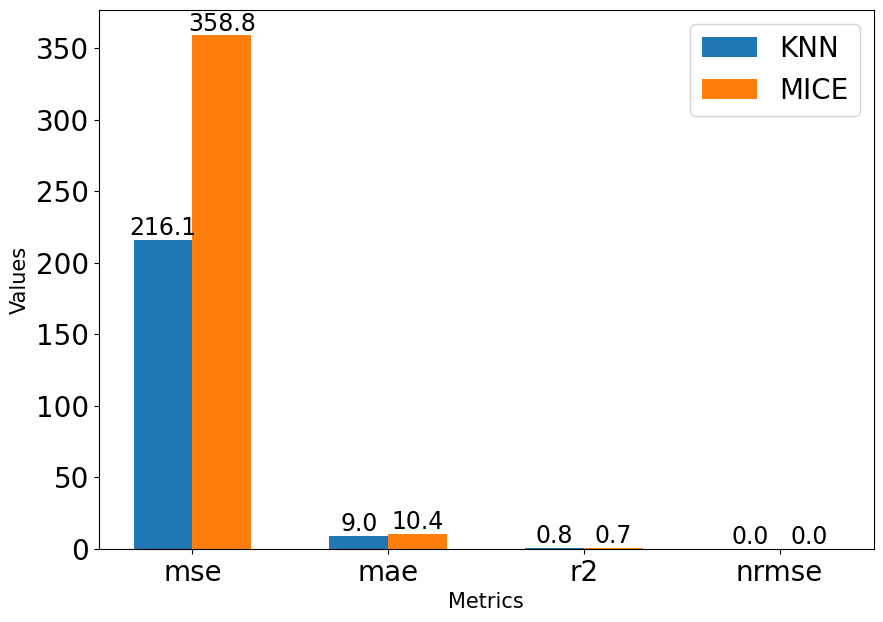

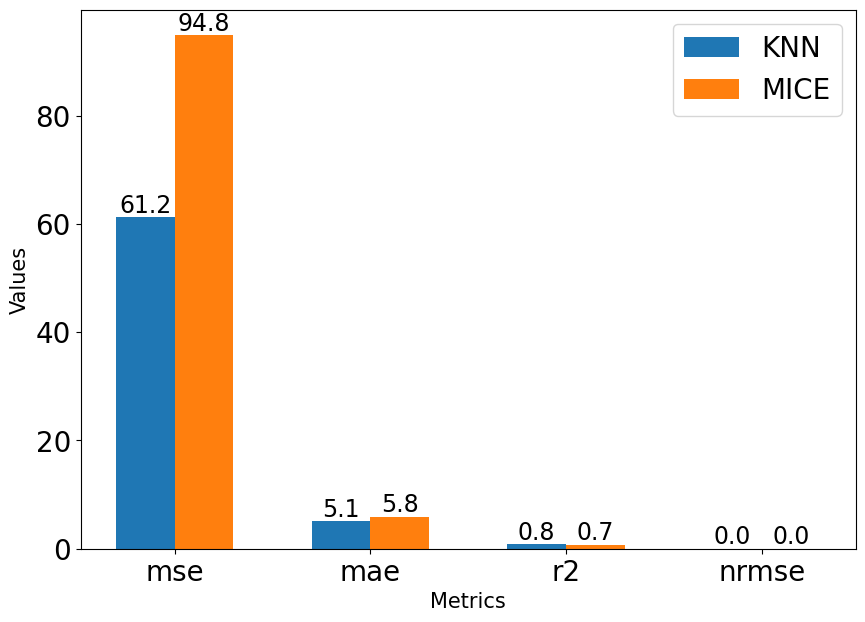

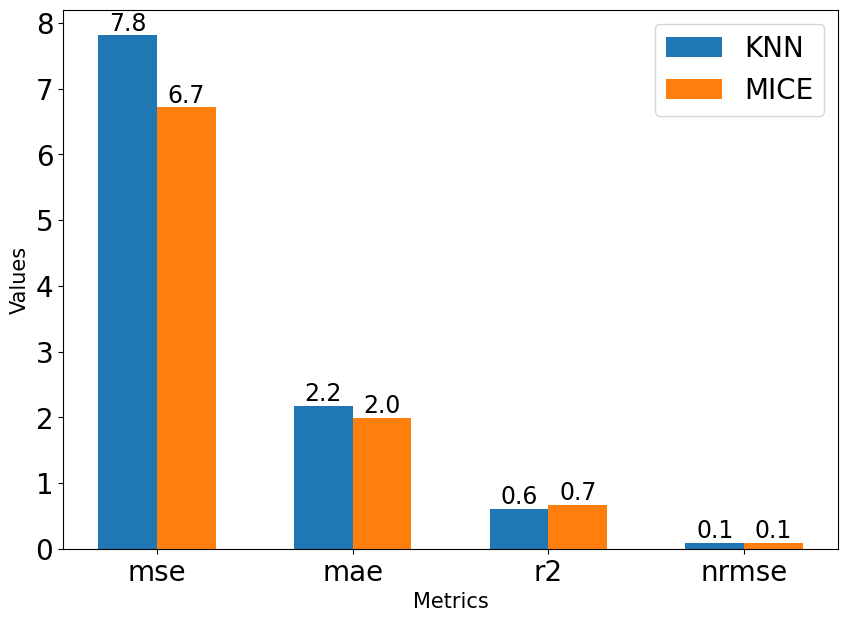

In [36]:
N = 4
ind = np.arange(N)  # the x locations for the groups
width = 0.3       # the width of the bars


for i in ['PTS', 'PM10', 'PM25']:
    # i = 'PM10'
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111)

    rects1 = ax.bar(ind, rf_metrics_knn_72[i], width)
    rects2 = ax.bar(ind+width, rf_metrics_mice_72[i], width)
    # rects3 = ax.bar(ind+width*2, rf_metrics_median[i], width)
    # rects4 = ax.bar(ind+width*3, rf_metrics_72[i], width)

    ax.set_ylabel('Values', fontsize=15, weight=55)
    ax.set_xlabel('Metrics', fontsize=15, weight=55)
    ax.set_xticks(ind+width*.5)
    ax.set_xticklabels( ('mse', 'mae', 'r2', 'nrmse'))
    ax.legend( (rects1[0], rects2[0]), ('KNN', 'MICE'), fontsize=20)

    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    def autolabel(rects):
        for rect in rects:
            h = rect.get_height()
            ax.text(rect.get_x()+rect.get_width()/2, 1.*h, float("{:.1f}".format(h)),
                    ha='center', va='bottom', fontsize=17, weight=55)

    autolabel(rects1)
    autolabel(rects2)
    # autolabel(rects3)
    # autolabel(rects4)

    plt.savefig(f"RFR{i}.png", transparent=True, bbox_inches='tight', dpi=500)

    plt.show()

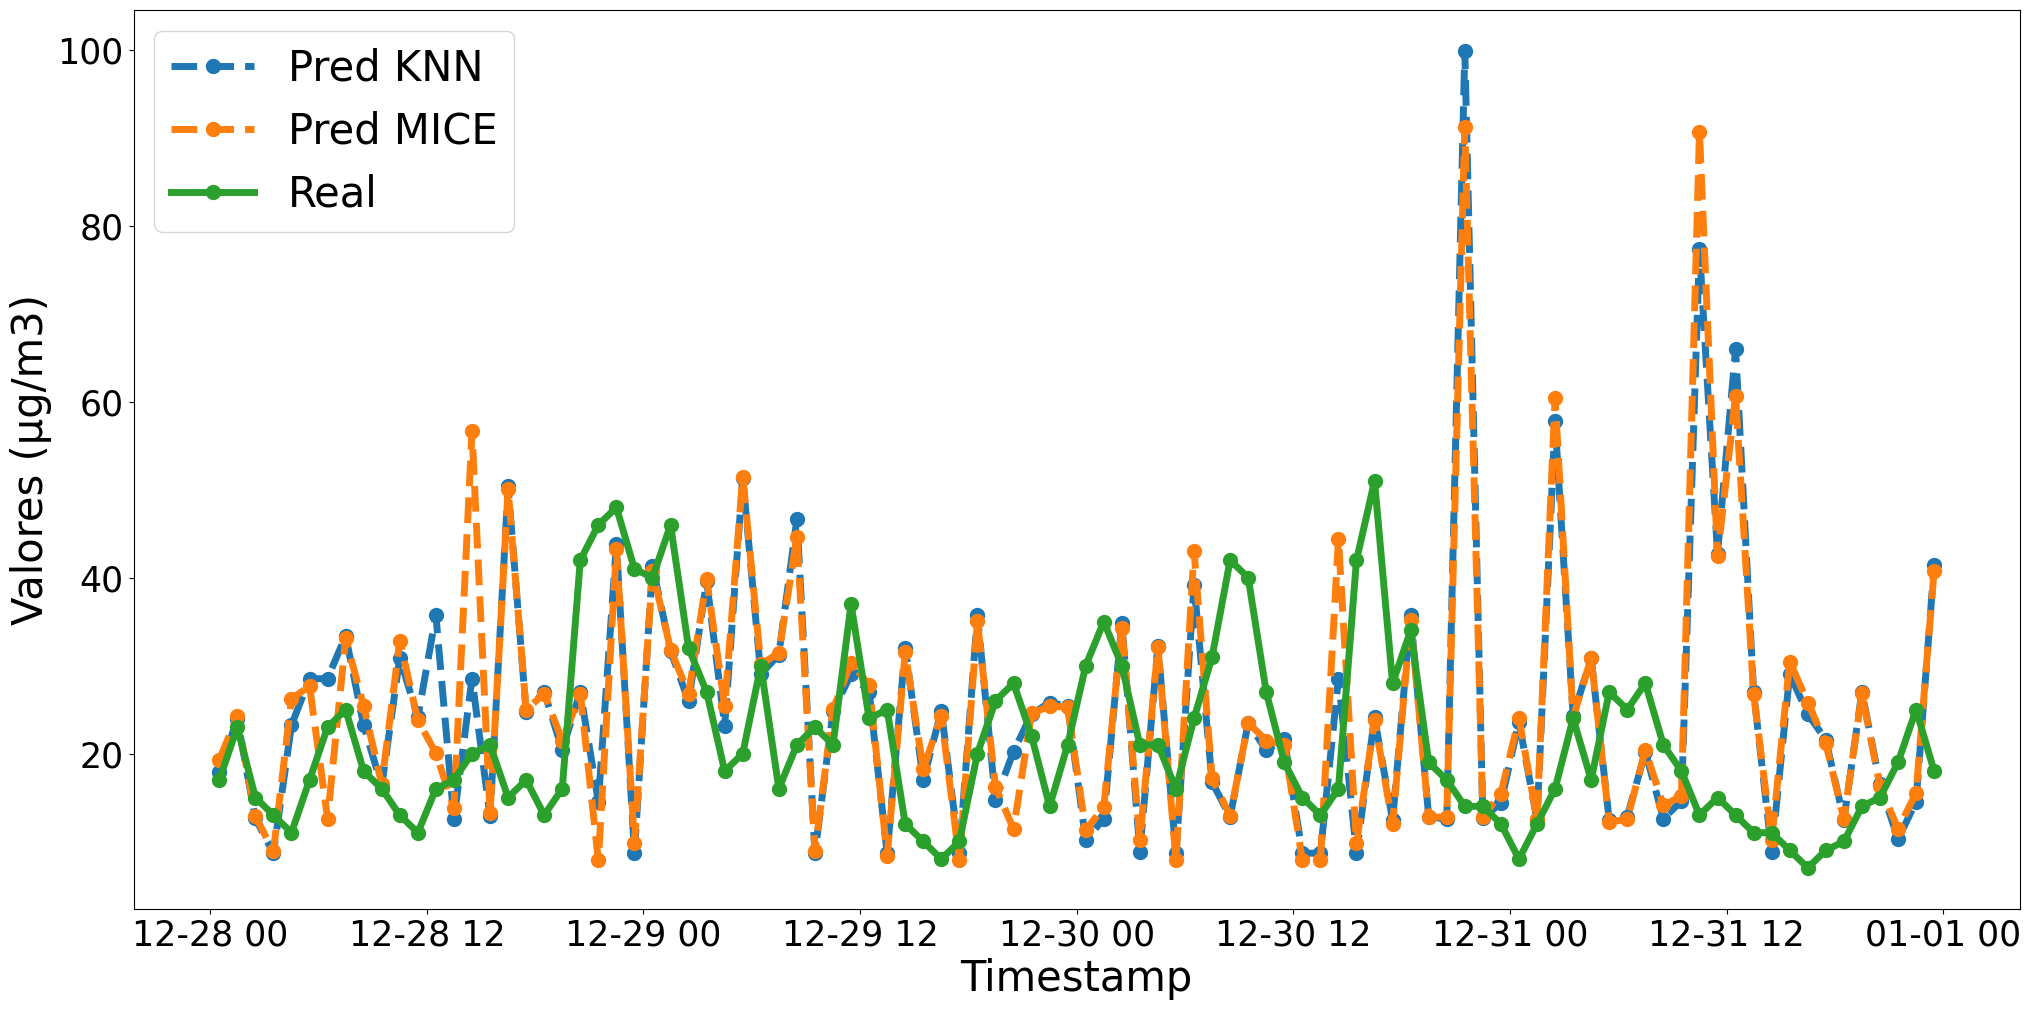

In [37]:
fig, axs = plt.subplots(1, 1, figsize=(20, 10))

foo = RF_df_knn_pm10.copy()
foo = foo[foo['Timestamp'].dt.year == 2022][-96:]
foo1 = RF_df_mice_pm10.copy()
foo1 = foo1[foo1['Timestamp'].dt.year == 2022][-96:]
# basilica = df['Basilica'][df['Basilica']['Timestamp'].dt.year == 2022][-96:]
basilica = df['Basilica'][df['Basilica']['Timestamp'].dt.year == 2022][-96:]
plt.plot(foo['Timestamp'], foo['PM10'], '.--', label='Pred KNN', markersize=20, linewidth=5)
plt.plot(foo1['Timestamp'], foo1['PM10'], '.--', label='Pred MICE', markersize=20, linewidth=5)
plt.plot(basilica['Timestamp'], basilica['PM10'], '.-', label='Real', markersize=20, linewidth=5)
# plt.vlines(basilica['Timestamp'].iloc[j],ymin=0,ymax=50)
plt.xlabel('Timestamp', fontsize=30)
plt.ylabel('Valores (µg/m3)', fontsize=30)
plt.legend(fontsize=30, loc='upper left')
plt.tight_layout()

plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

plt.savefig("prophet_PM10_values.png", transparent=True, bbox_inches='tight')

plt.show()